In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import itertools

import awkward as ak
import numpy as np
from python.analysis import cross_section, Plots, Tags, PFOSelection, SelectionTools, vector

from apps import cex_analysis_input

cross_section.SetPlotStyle(dark = False, extend_colors = True, dpi = 100)

class CutOptimiser:
    def __init__(self, x : ak.Array, signal : ak.Array, n_cuts : int = 1, n_step = 50, x_range = None) -> None:
        self.x = x
        self.signal = signal
        self.n_cuts = n_cuts
        self.n_step = n_step
        self.x_range = x_range
        pass

    def p(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(selected_signal)

    def e(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(self.signal)

    def pe(self, selected_signal):
        return self.p(selected_signal) * self.e(selected_signal)

    def sb(self, selected_signal):
        return ak.sum(selected_signal) / ak.sum(~selected_signal)

    def ssb(self, selected_signal):
        return ak.sum(selected_signal) / np.sqrt(ak.sum(~selected_signal))

    def Optimise(self, score : callable, plot : bool = False):
        if self.x_range is None:
            cut_values = np.linspace(ak.min(self.x), ak.max(self.x), self.n_step)
        else:
            cut_values = np.linspace(min(self.x_range), max(self.x_range), self.n_step)

        score_l = []
        score_g = []
        for c in cut_values:
            mask = self.x < c
            score_l.append(score(self.signal[mask]))
            score_g.append(score(self.signal[~mask]))

        max_l = np.nanargmax(score_l)
        max_g = np.nanargmax(score_g)
        
        if score_l[max_l] > score_g[max_g]:
            op = "<"
            cut_value = cut_values[max_l]
        else:
            op = ">"
            cut_value = cut_values[max_g]

        if plot is True:
            Plots.Plot(cut_values, score_l, xlabel = "cut value", ylabel = "score", label = "x < c", newFigure = False)
            Plots.Plot(cut_values, score_g, label = "x > c", newFigure = False)
            Plots.Plot(cut_values[max_l], score_l[max_l], marker = "X", newFigure = False)
            Plots.Plot(cut_values[max_g], score_g[max_g], marker = "X", newFigure = False)
        return cut_value, op

    def visualise(self, cut_value, cut_op, tags : Tags = None, x_label = None):
        if tags is None:
            tags = Tags.Tags()
            tags["signal"] = Tags.Tag(name = "signal", mask = self.signal, colour = "C6", number = 0)
            tags["background"] = Tags.Tag(name = "background", mask = ~self.signal, colour = "C0", number = 1)
        Plots.PlotTagged(self.x, tags, x_label = x_label, x_range = self.x_range, truncate = self.x_range is not None, newFigure = False)
        
        if self.x_range is None:
            l = ak.max(self.x)
        else:
            l = max(self.x_range)
        Plots.DrawCutPosition(cut_value, face = cut_op, arrow_length = 0.1 * l)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [27]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_config.json"))
# args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("test/analysis_1GeV/analysis_config.json"))

In [28]:
mc = cross_section.Data(args.mc_file, nTuple_type = cross_section.Ntuple_Type.PDSP, target_momentum = args.pmom)

In [29]:
mc_beam = cex_analysis_input.BeamPionSelection(mc, args, True)
reco_regions, true_regions = cex_analysis_input.RegionSelection(mc, args, True)

'BeamPionSelection' executed in 0.0249s

'RegionSelection' executed in 8.2087s

In [5]:
def visualise_bar(v, reco_region : str, label : str):
    Plots.PlotBar(v[reco_regions[reco_region]], xlabel = f"{label} n PFOs in {cross_section.remove_(reco_region)} region")

    bars = {}
    for _, t in Plots.IterMultiPlot(true_regions):
        mask = reco_regions[reco_region] & true_regions[t]
        i, c = np.unique(v[mask], return_counts = True)
        bars[t] = [i, c/sum(c)]

        Plots.PlotBar(v[mask], xlabel = f"{label} in {cross_section.remove_(reco_region)} region", title = cross_section.remove_(t), newFigure = False)

    Plots.PlotStackedBar(list(bars.values()), list(bars.keys()))
    return

# Reco PFO Properties

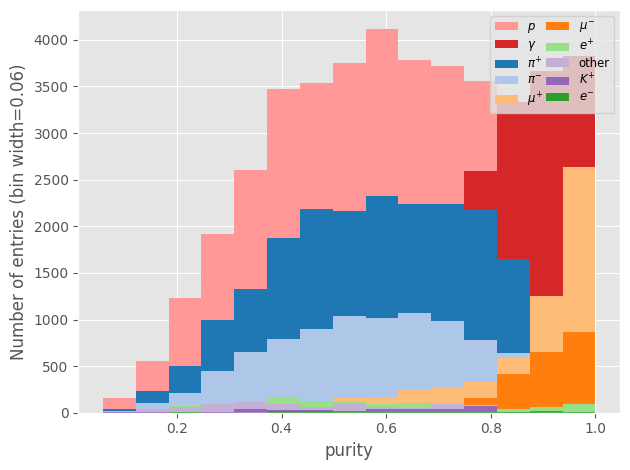

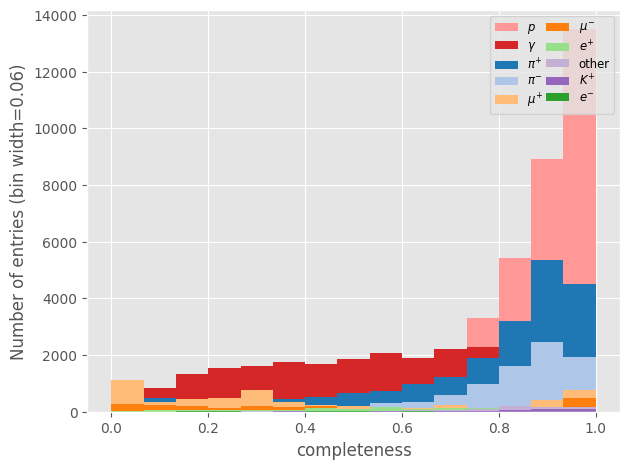

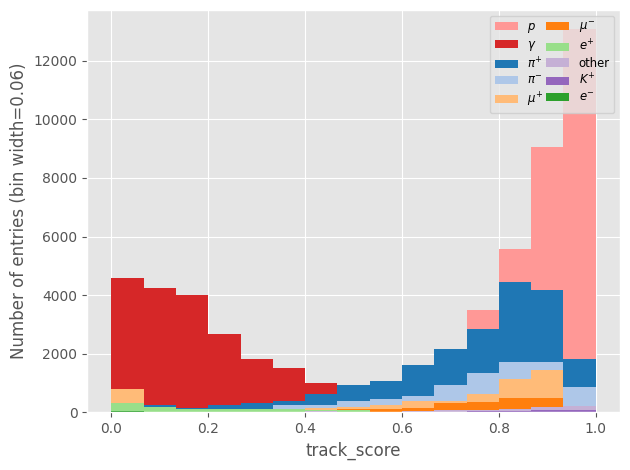

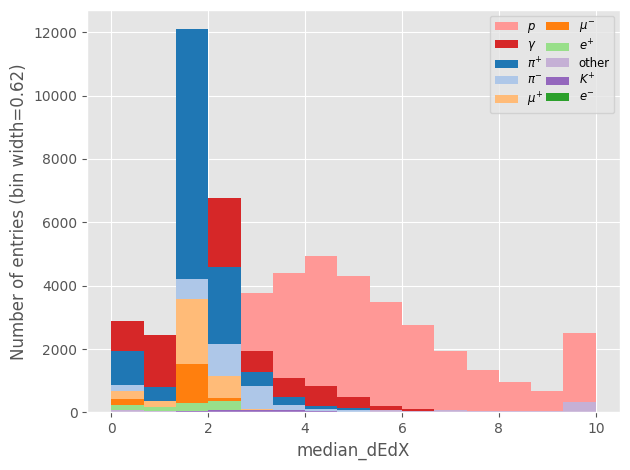

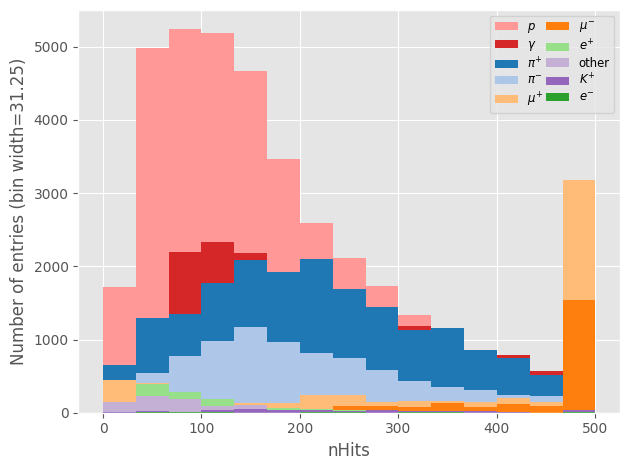

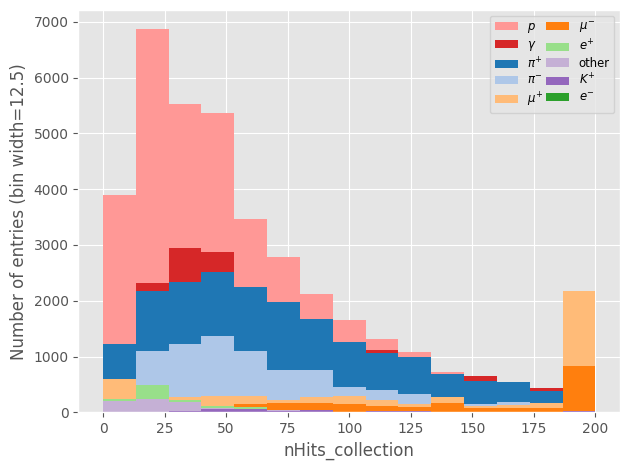

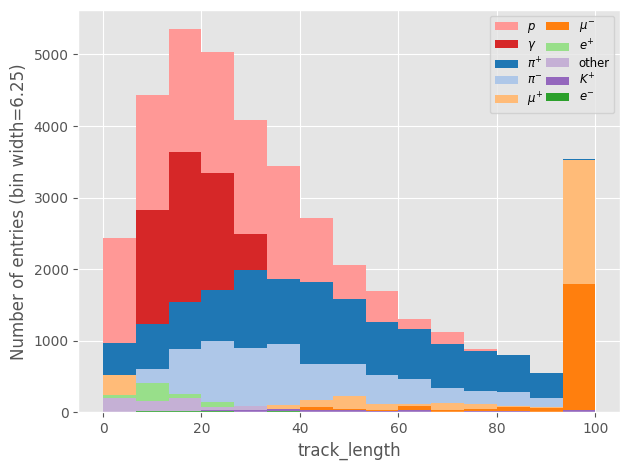

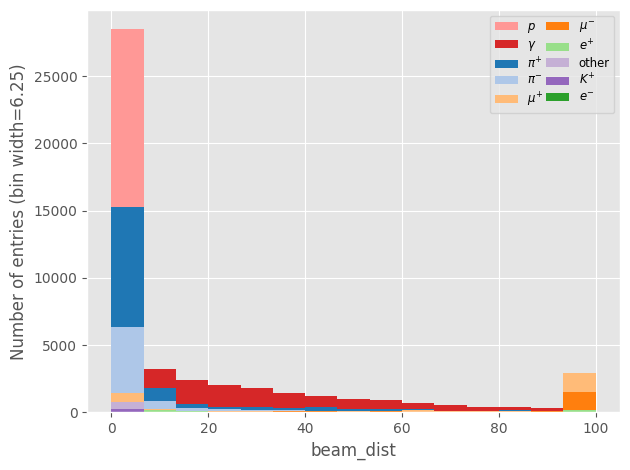

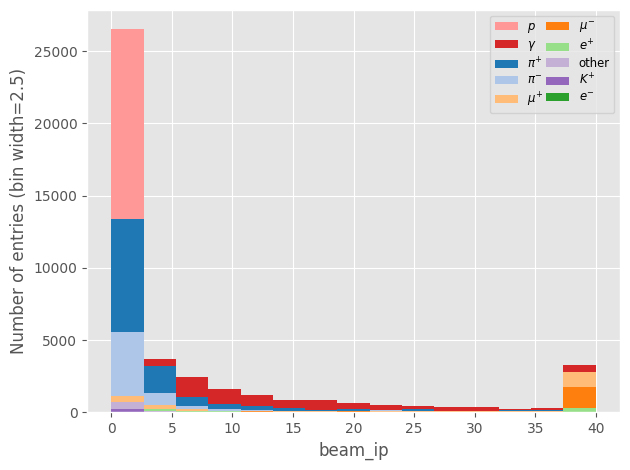

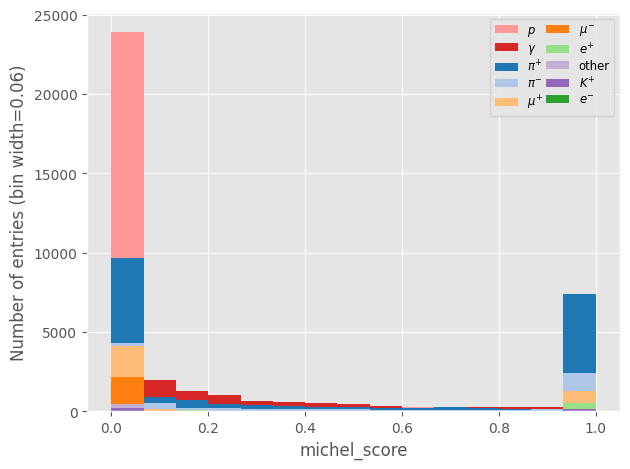

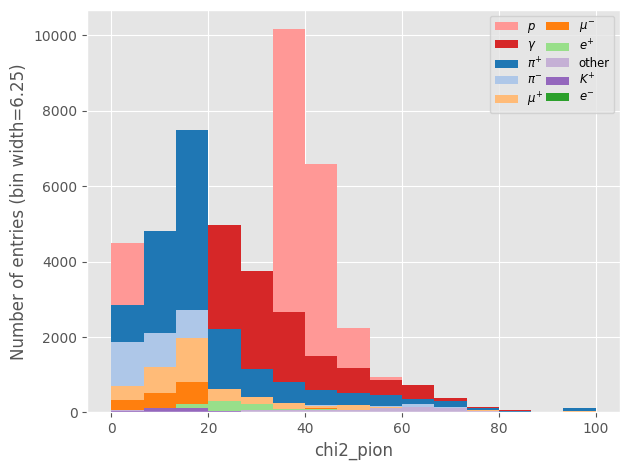

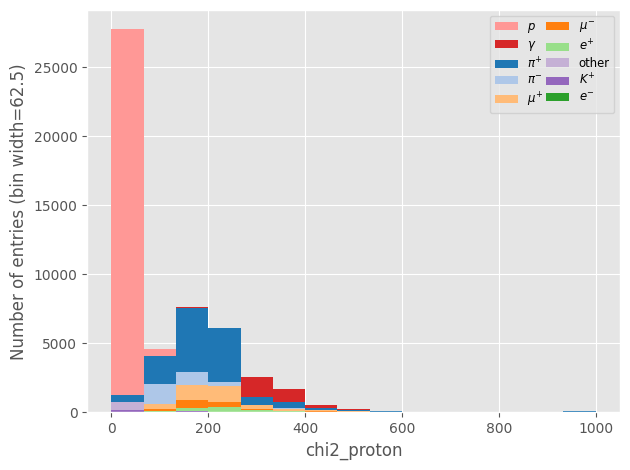

In [88]:
photon_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["photon"])
pi_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["pi"])

mask = reco_regions["charge_exchange"]

mask = mask & ~(photon_mask | pi_mask) # look at PFOs which were not identified as anything

mask = np.ones_like(mc_beam.recoParticles.number)

tags = Tags.GenerateTrueParticleTags(mc_beam)

for t in tags:
    tags[t].mask = tags[t].mask[mask]

observables = {
    "purity" : mc_beam.trueParticlesBT.purity,
    "completeness" : mc_beam.trueParticlesBT.completeness,
    "track_score" : PFOSelection.TrackScoreCut(mc_beam, return_property = True)[1],
    "median_dEdX" : PFOSelection.PiPlusSelection(mc_beam, return_property = True)[1],
    "nHits" : PFOSelection.NHitsCut(mc_beam, return_property = True)[1],
    "nHits_collection" : mc_beam.recoParticles.n_hits_collection,
    "track_length" : mc_beam.recoParticles.track_len,
    "beam_dist" : PFOSelection.BeamParticleDistanceCut(mc_beam, return_property = True)[1],
    "beam_ip" : PFOSelection.BeamParticleIPCut(mc_beam, return_property = True)[1],
    "michel_score" : mc_beam.recoParticles.track_vertex_michel,
    "chi2_pion" : mc_beam.recoParticles.track_chi2_pion / mc_beam.recoParticles.track_chi2_pion_ndof,
    "chi2_proton" : mc_beam.recoParticles.track_chi2_proton / mc_beam.recoParticles.track_chi2_proton_ndof
}

ranges = {
    "purity"           : None,
    "completeness"     : None,
    "track_score"      : None,
    "median_dEdX"      : [0, 10],
    "nHits"            : [0, 500],
    "nHits_collection" : [0, 200],
    "track_length"     : [0, 100],
    "beam_dist"        : [0, 100],
    "beam_ip"          : [0, 40],
    "michel_score"     : [0, 1],
    "chi2_pion"        : [0, 100],
    "chi2_proton"      : [0, 1000]
}

for (n, o), r in zip(observables.items(), ranges.values()):
    Plots.PlotTagged(o[mask], tags, bins = 15, x_label = n, x_range = r, truncate = r is not None, stacked = False, reverse_sort = True)

In [89]:
pi = (tags.number[0].mask) | (tags.number[1].mask)
gamma = tags.number[6].mask
p = tags.number[7].mask

In [114]:
with Plots.PlotBook("correlation_plots.pdf", True) as book:
    for _, c in Plots.IterMultiPlot(list(itertools.product(observables.keys(), repeat = 2)), threshold = 200):
        Plots.Plot(ak.ravel(observables[c[0]][mask][gamma]), ak.ravel(observables[c[1]][mask][gamma]), label = "$\gamma$", marker = "o", linestyle = "", newFigure = False, color = "C1", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][p]), ak.ravel(observables[c[1]][mask][p]), label = "$p$", marker = "o", linestyle = "", newFigure = False, color = "C2", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][pi]), ak.ravel(observables[c[1]][mask][pi]), label = "$\pi^{\pm}$", marker = "o", linestyle = "", newFigure = False, color = "C0", alpha = 0.33, xlabel = c[0], ylabel = c[1])
        Plots.plt.xlim(ranges[c[0]])
        Plots.plt.ylim(ranges[c[1]])
    book.Save()
    Plots.plt.close()

pdf correlation_plots.pdf has been opened
pdf correlation_plots.pdf has been closed


In [32]:
for k, v in {"pi" : pi, "p" : p, "gamma" : gamma}.items():
    with Plots.PlotBook(k) as book:
        cut_op = CutOptimiser(None, v, n_step = 25)
        for o in observables:
            cut_op.x = observables[o][mask]
            cut_op.x_range = ranges[o]
            plot = Plots.MultiPlot(2)
            next(plot)
            results = cut_op.Optimise(cut_op.pe, plot = True)
            Plots.plt.title(o)
            next(plot)
            cut_op.visualise(*results, tags = tags, x_label = o)
            book.Save()
    Plots.plt.close("all")

pdf pi.pdf has been opened


/tmp/ipykernel_24213/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf pi.pdf has been closed
pdf p.pdf has been opened


/tmp/ipykernel_24213/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf p.pdf has been closed
pdf gamma.pdf has been opened


/tmp/ipykernel_24213/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf gamma.pdf has been closed


# Optimise Cuts

In [33]:
def CreateOptimisedSelection(x, signal, x_range, mask = None, invert = False):
    if mask is None:
        mask = np.ones_like(x, dtype = bool)
    cut_op = CutOptimiser(x[mask], signal[mask], x_range = x_range)
    cut = list(cut_op.Optimise(cut_op.pe))
    if invert:
        if cut[1] == "<":
            cut[1] = ">"
        elif cut[1] == ">":
            cut[1] = "<"
        else:
            pass
    func = SelectionTools.cuts_to_func(*cut)
    return cut, func, func(x)

In [51]:
current_track_score_mask = args.selection_masks["mc"]["pi"]["TrackScoreCut"]
current_nHits_mask = args.selection_masks["mc"]["pi"]["NHitsCut"]

/tmp/ipykernel_24213/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


charged $\pi$, 0.74
charged $\pi$:2nd, 0.49
$\mu^{-}$, 0.11
$\mu^{+}$, 0.28
$e^{+}$, 0.13
$\gamma$, 0.08
$p$, 0.16
other, 0.16


/tmp/ipykernel_24213/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


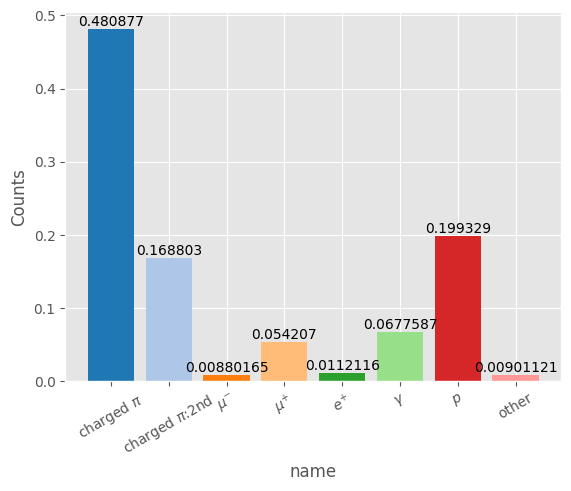

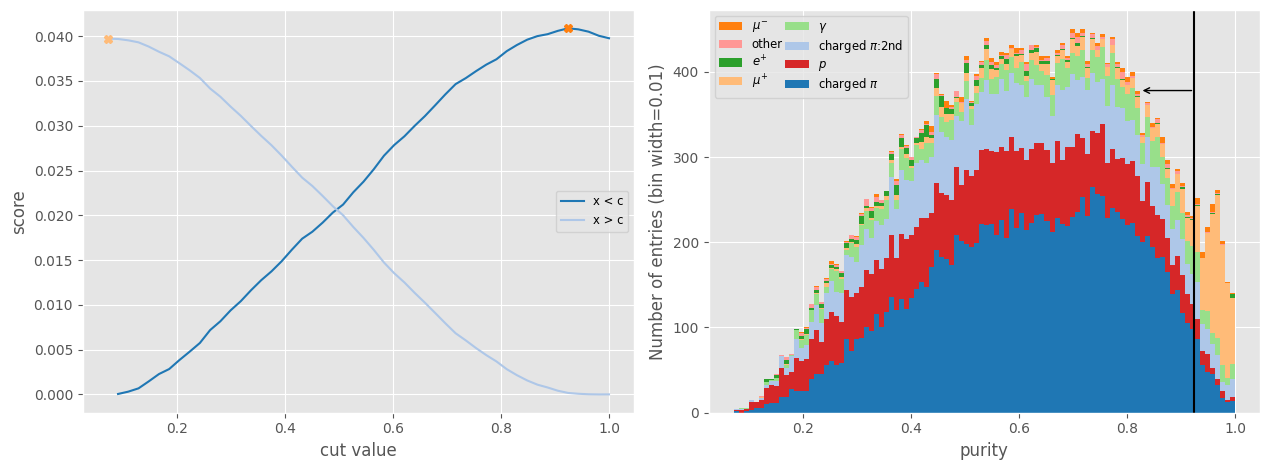

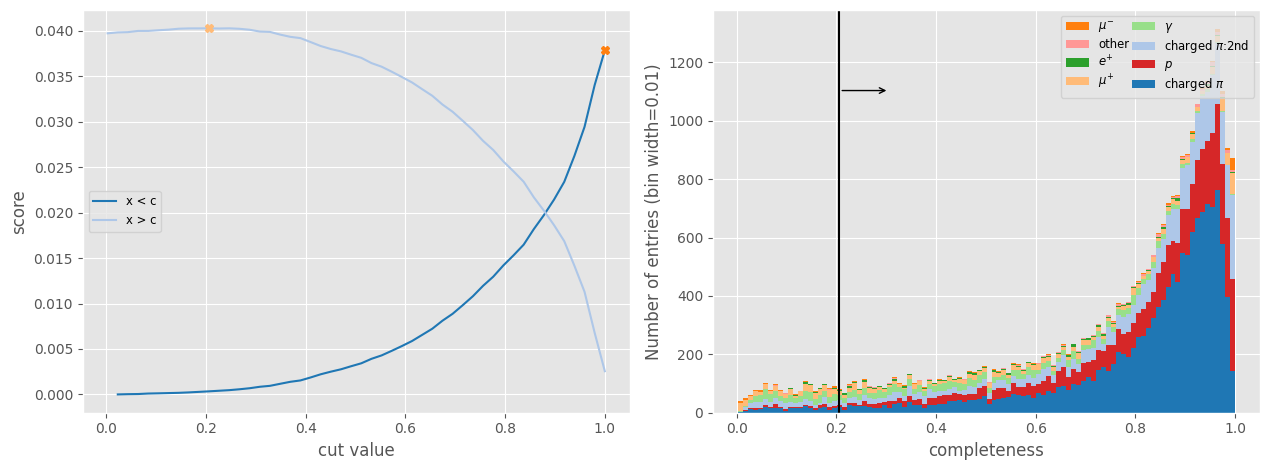

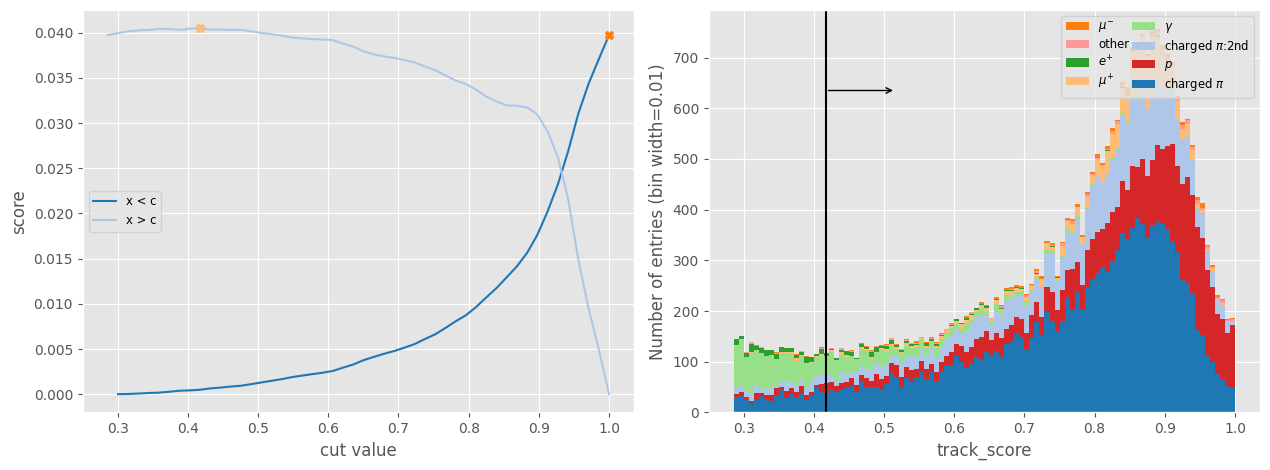

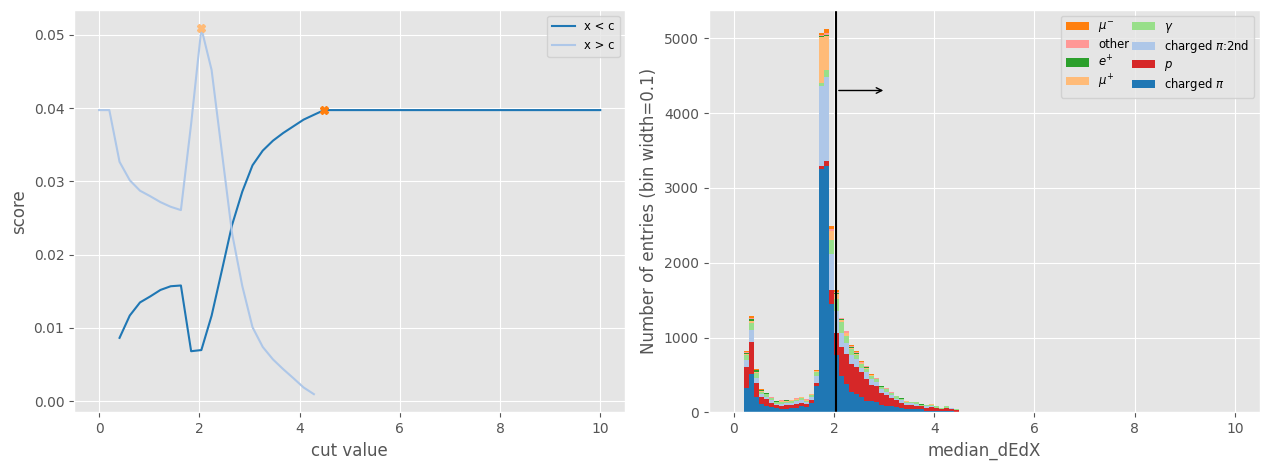

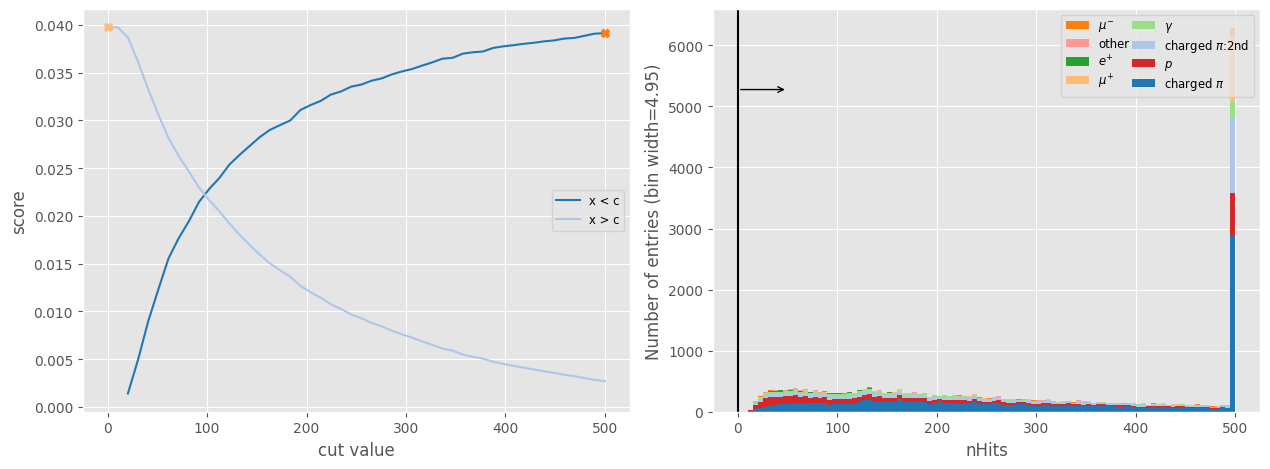

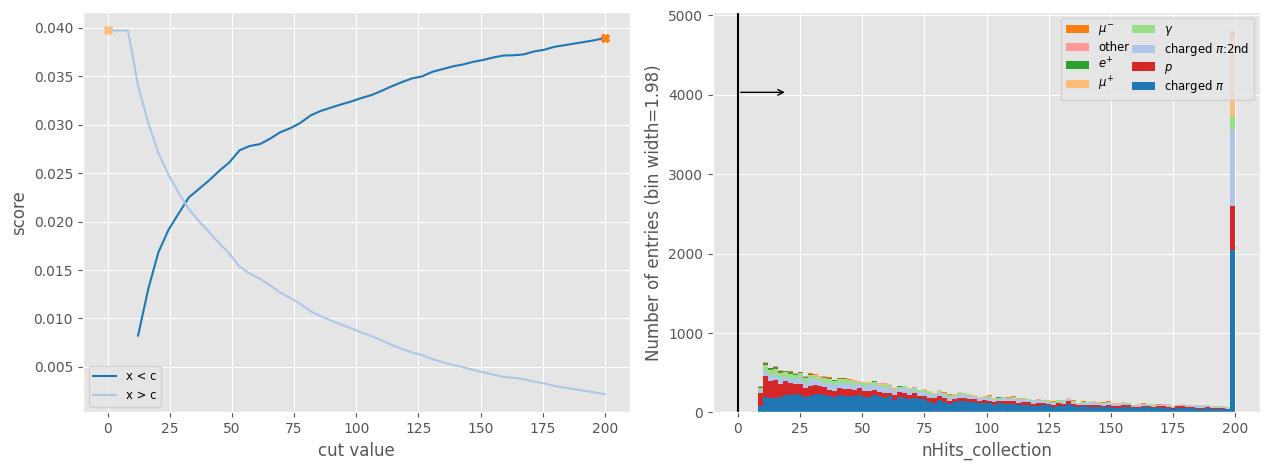

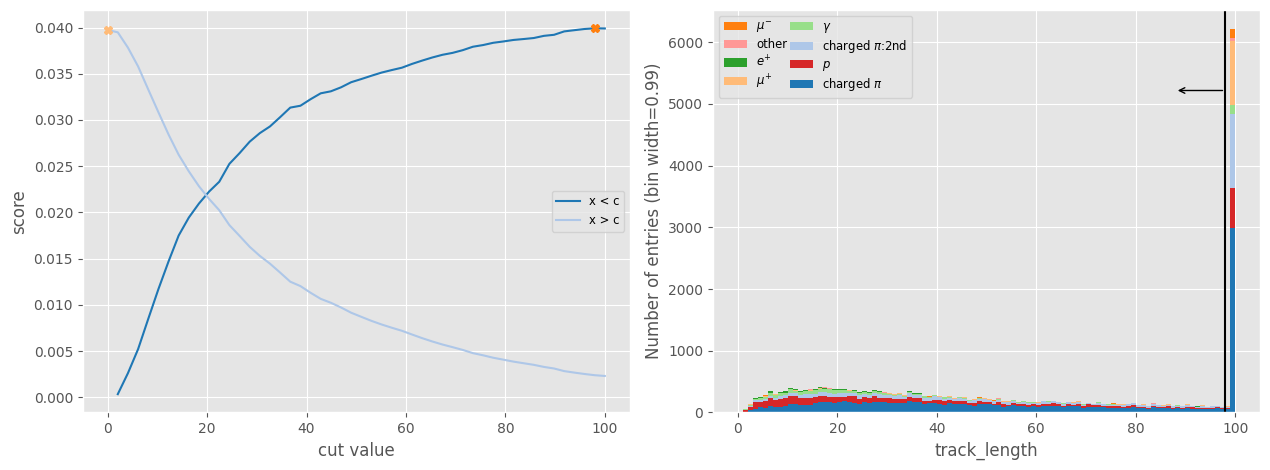

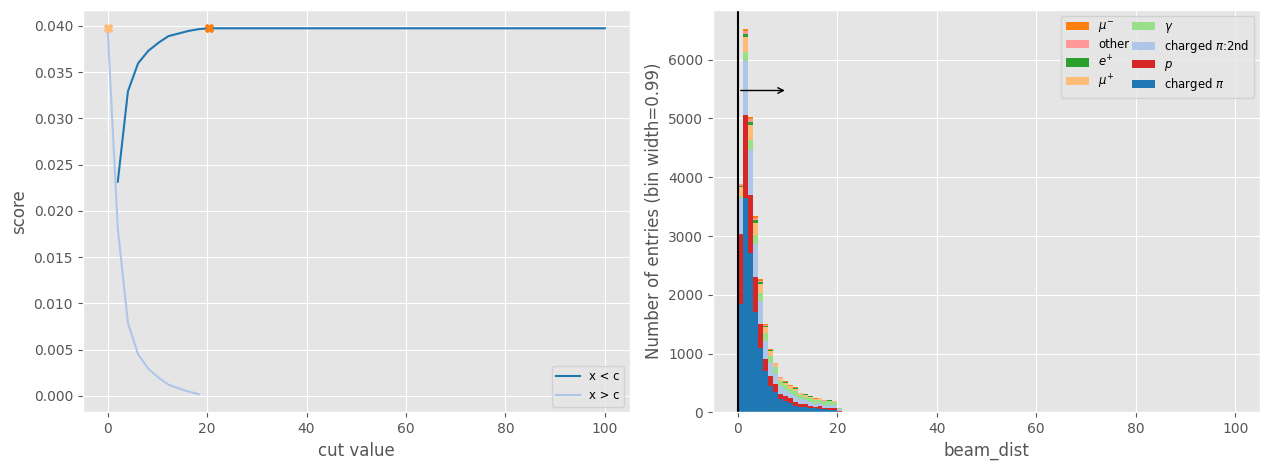

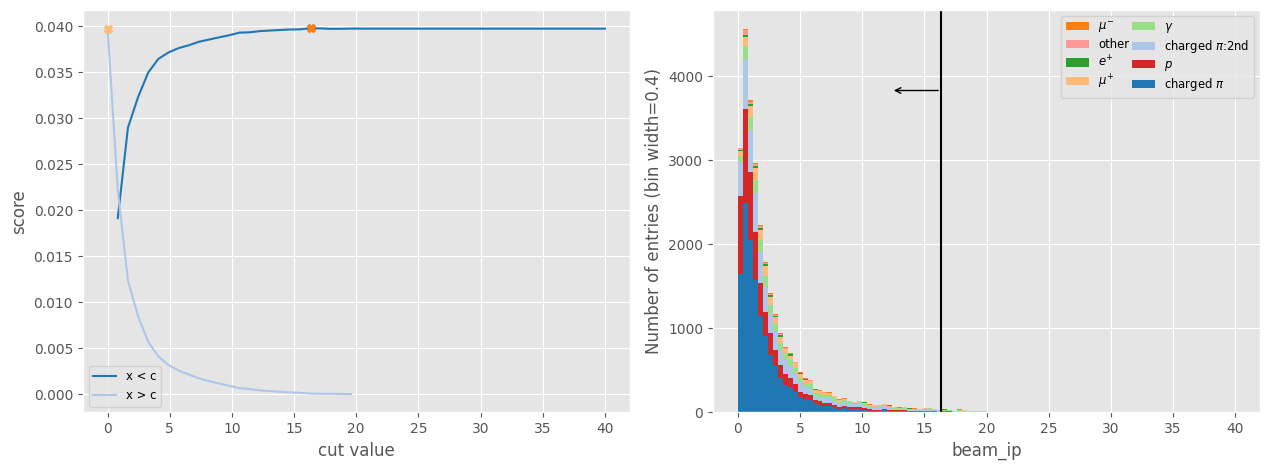

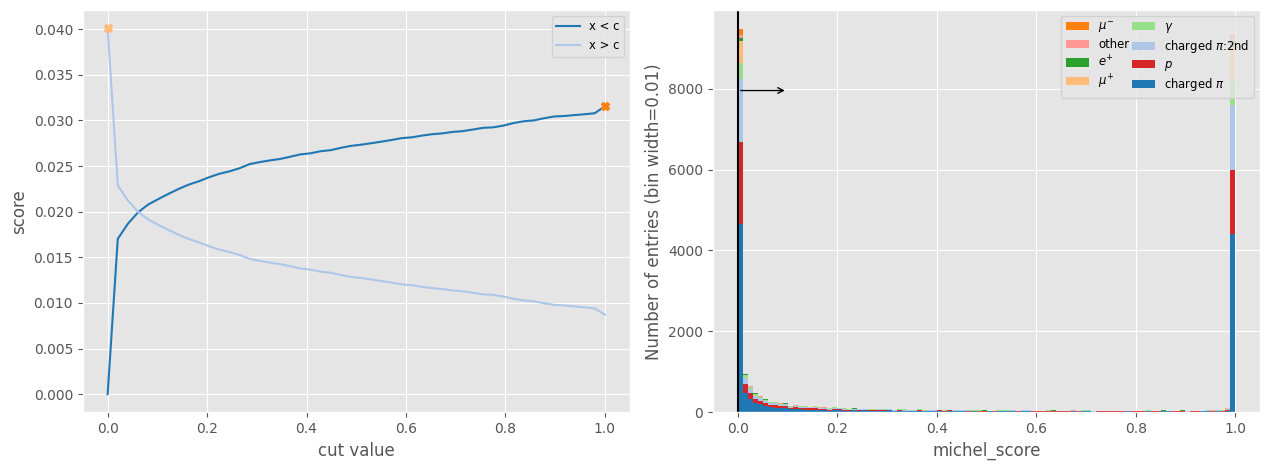

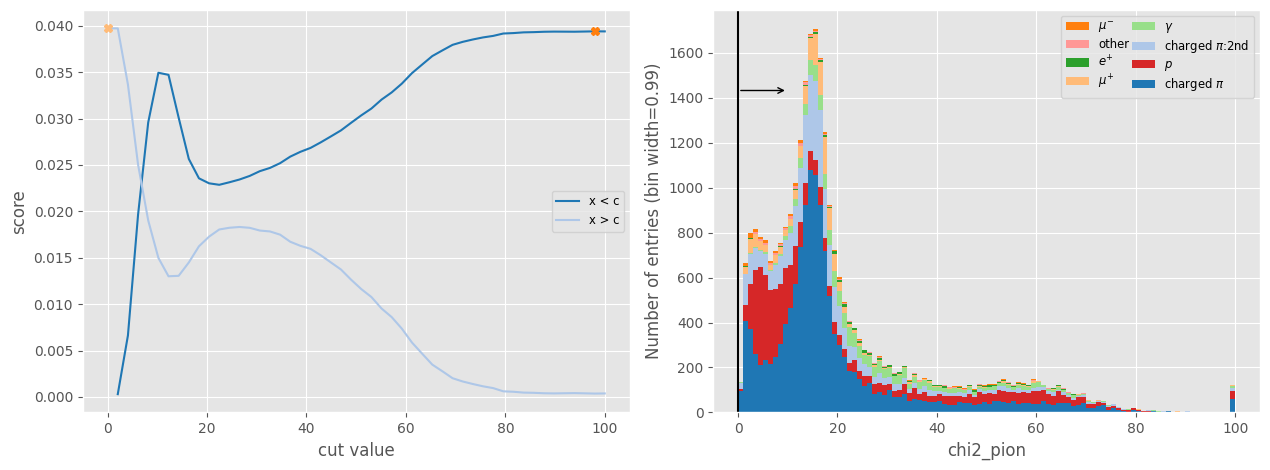

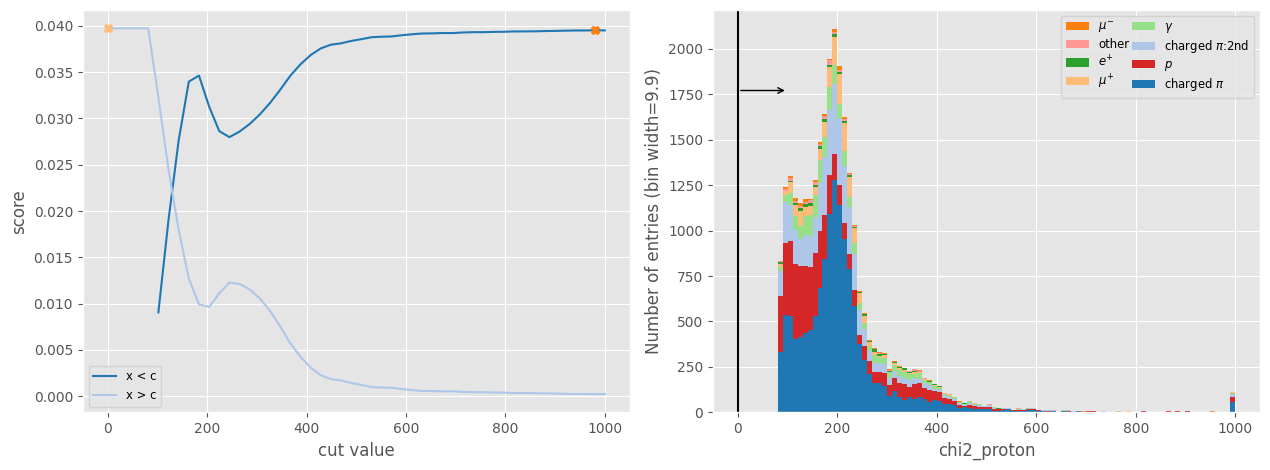

In [133]:
original_tags = Tags.GenerateTrueParticleTagsPiPlus(mc_beam)

pi = original_tags.number[0].mask
p = original_tags.number[6].mask

pion_selection = {}
pion_selection_mask = {}
selected_mask = None
track_score_cut, pion_selection["track_score"], pion_selection_mask["track_score"] = CreateOptimisedSelection(observables["track_score"], pi, x_range = ranges["track_score"], mask = selected_mask)
selected_mask = SelectionTools.CombineMasks(pion_selection_mask)

beam_dist_cut, pion_selection["beam_dist"], pion_selection_mask["beam_dist"] = CreateOptimisedSelection(observables["beam_dist"], pi, x_range = ranges["beam_dist"], mask = selected_mask)
selected_mask = SelectionTools.CombineMasks(pion_selection_mask)

chi2_proton_cut, pion_selection["chi2_proton"], pion_selection_mask["chi2_proton"] = CreateOptimisedSelection(observables["chi2_proton"], pi, x_range = ranges["chi2_proton"], mask = selected_mask)
selected_mask = SelectionTools.CombineMasks(pion_selection_mask)

nHits_collection_cut, pion_selection["nHits_collection"], pion_selection_mask["nHits_collection"] = CreateOptimisedSelection(observables["nHits_collection"], pi, x_range = ranges["nHits_collection"], mask = selected_mask)
selected_mask = SelectionTools.CombineMasks(pion_selection_mask)

_, pion_selection["median_dEdX"], pion_selection_mask["median_dEdX"] = CreateOptimisedSelection(observables["median_dEdX"], pi, x_range = ranges["median_dEdX"], mask = selected_mask)
selected_mask = SelectionTools.CombineMasks(pion_selection_mask)


# chi2_pion_cut, pion_selection["chi2_pion"], pion_selection_mask["chi2_pion"] = CreateOptimisedSelection(observables["chi2_pion"], pi, x_range = ranges["chi2_pion"], mask = selected_mask)
# selected_mask = SelectionTools.CombineMasks(pion_selection_mask)




tags_poor_pi = Tags.GenerateTrueParticleTagsPiPlus(mc_beam)

for t in tags_poor_pi:
    tags_poor_pi[t].mask = tags_poor_pi[t].mask[selected_mask]

for t in original_tags:
    print(f"{t}, {ak.sum(tags_poor_pi[t].mask) / ak.sum(original_tags[t].mask):.2f}")

Plots.PlotTags(tags_poor_pi, fraction = True)

cut_op = CutOptimiser(None, p[selected_mask])
for o in observables:
    cut_op.x = observables[o][selected_mask]
    cut_op.x_range = ranges[o]
    plot = Plots.MultiPlot(2)
    next(plot)
    results = cut_op.Optimise(cut_op.pe, plot = True)
    next(plot)
    cut_op.visualise(*results, tags = tags_poor_pi, x_label = o)

In [142]:
# for r in reco_regions:
#     for t in true_regions:
#         print(t, r, ak.sum(original_tags.number[3].mask & selected_mask & true_regions[t] & reco_regions[r]))

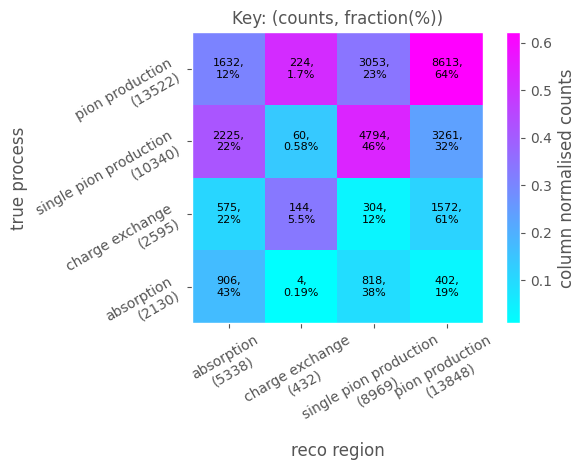

In [155]:
new_pi_count = ak.sum(selected_mask, -1)
old_pi0_count = SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])

# reco_regions_new_pi = cross_section.EventSelection.create_regions_new(old_pi0_count, new_pi_count)
reco_regions_new_pi = create_regions_alt(old_pi0_count, new_pi_count, SelectionTools.GetPFOCounts(args.selection_masks["mc"]["photon"]))


counts_new_pi_selection = cross_section.Toy.ComputeCounts(true_regions, reco_regions_new_pi)

Plots.PlotConfusionMatrix(counts_new_pi_selection, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")


/tmp/ipykernel_14582/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)
/tmp/ipykernel_14582/1992280737.py:29: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


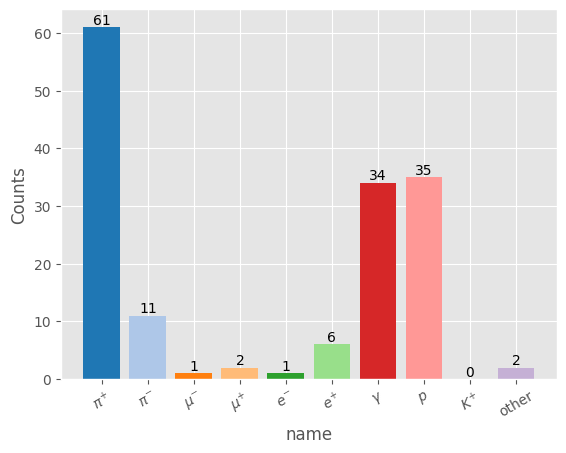

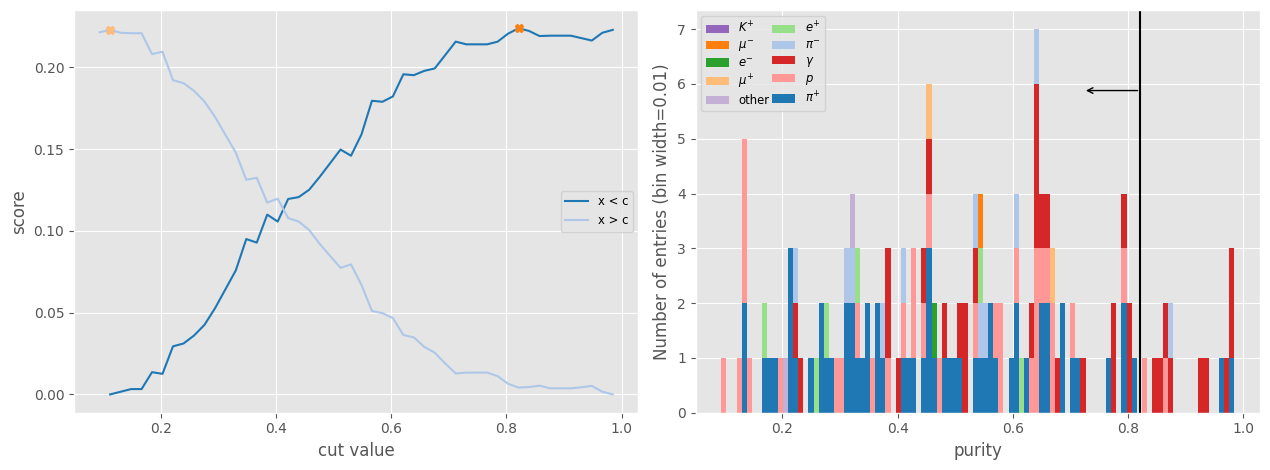

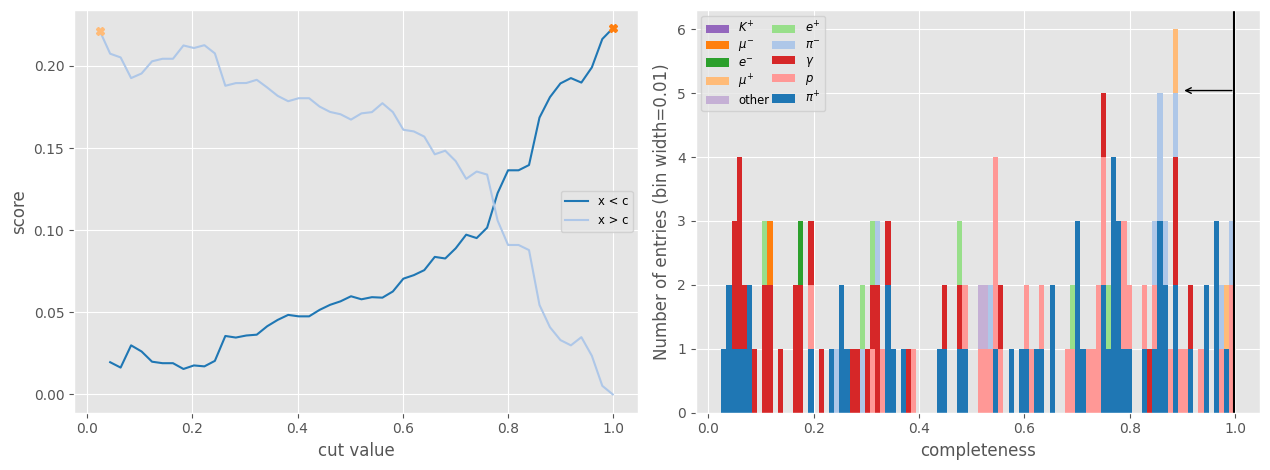

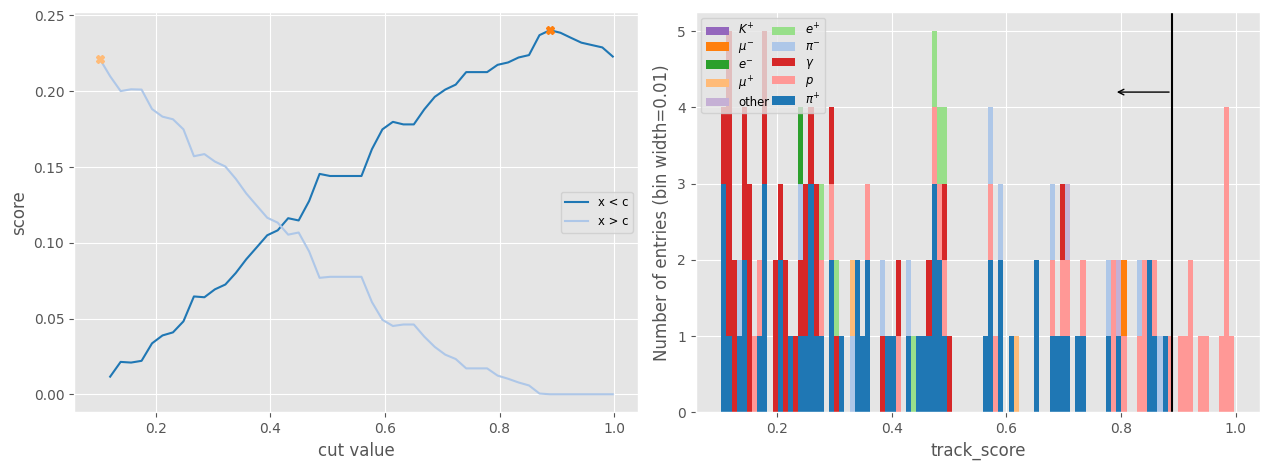

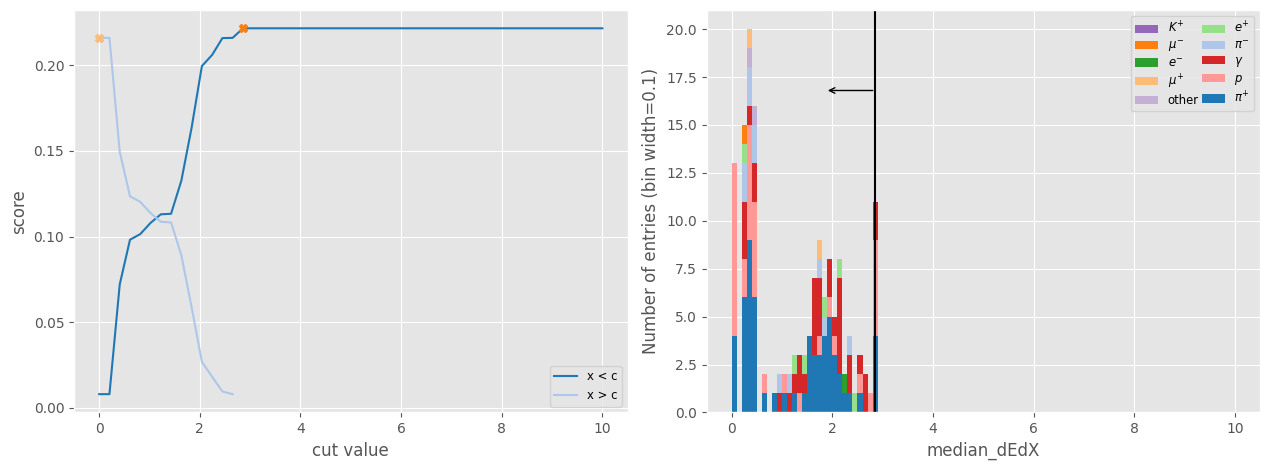

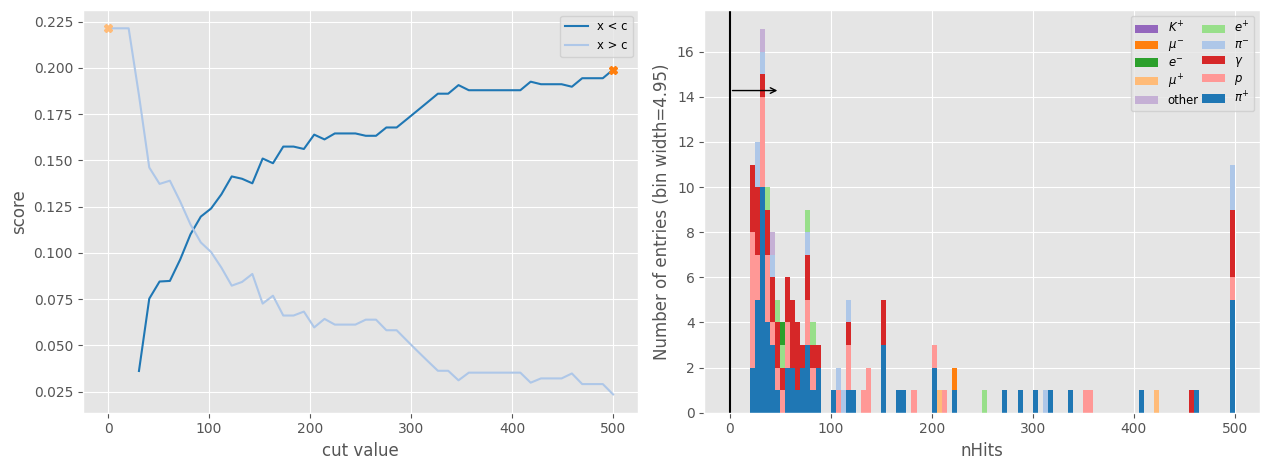

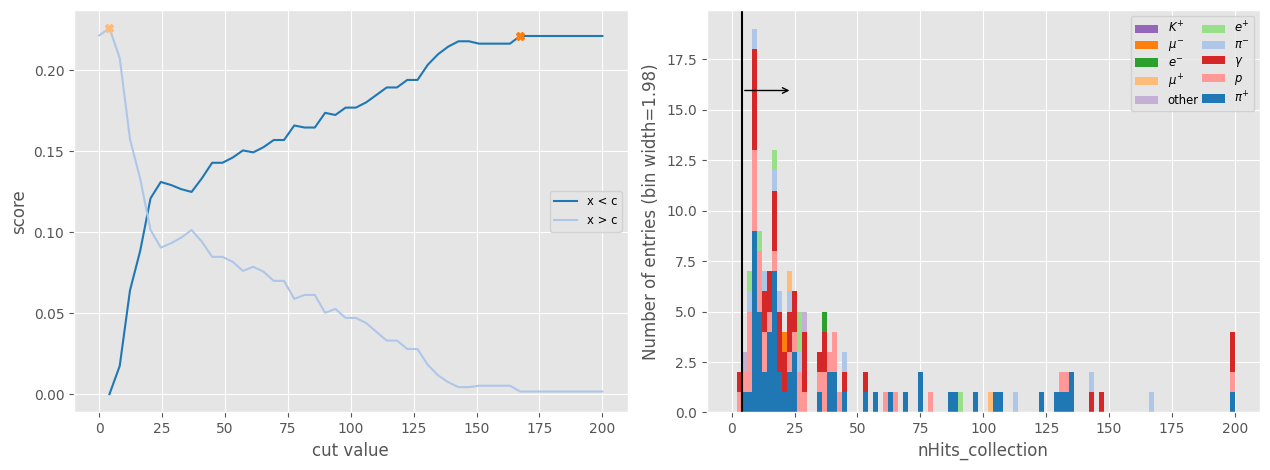

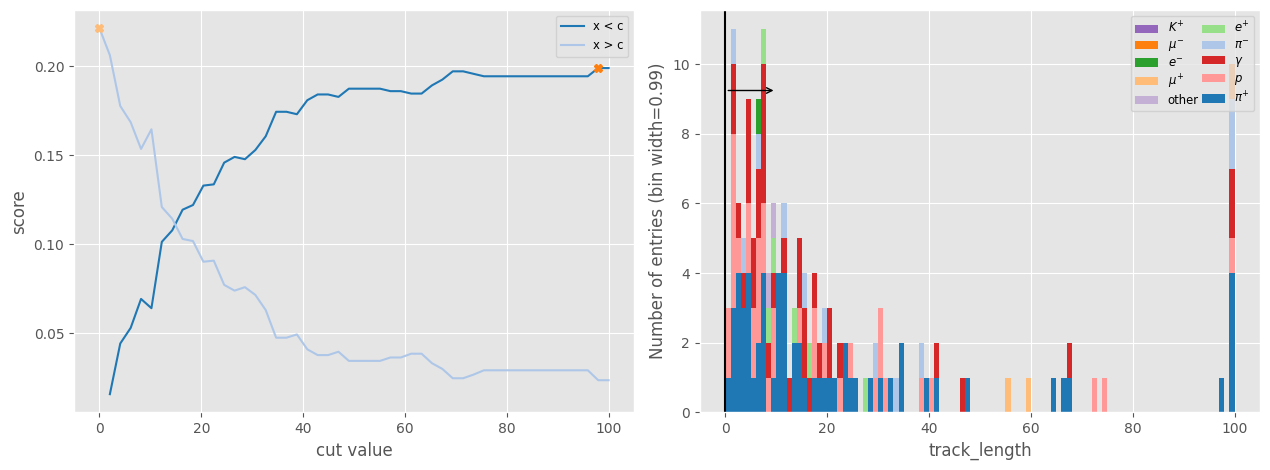

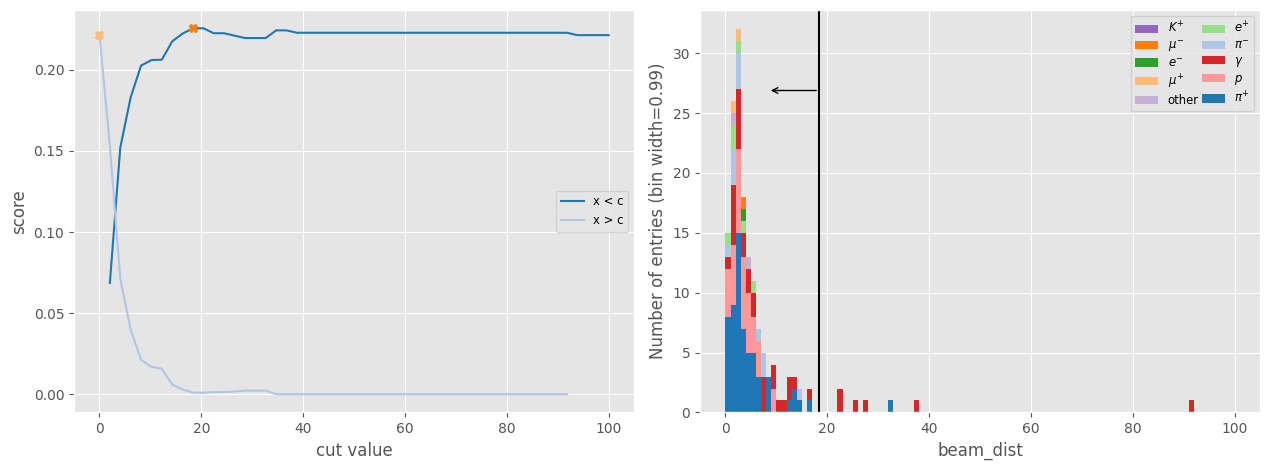

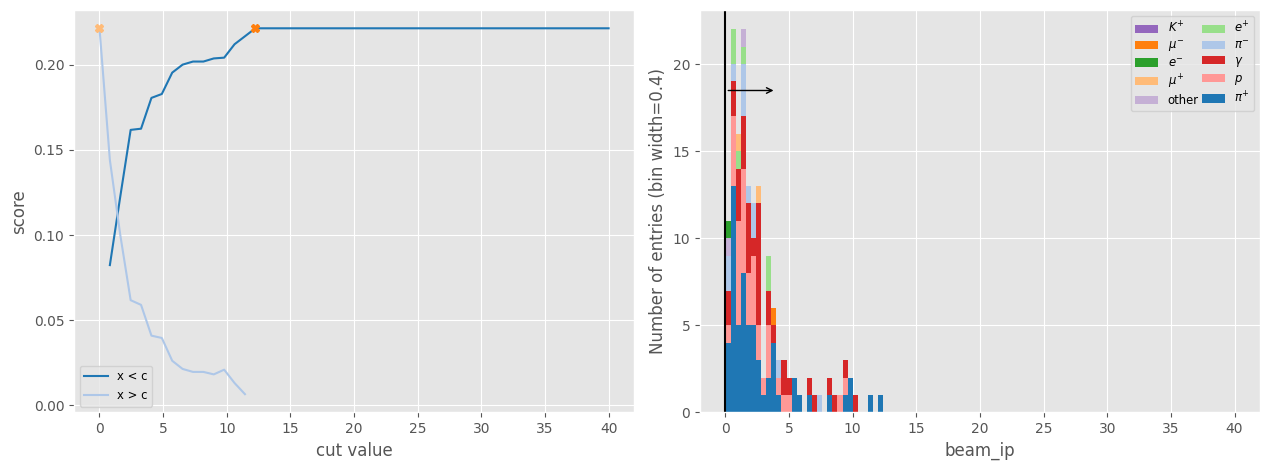

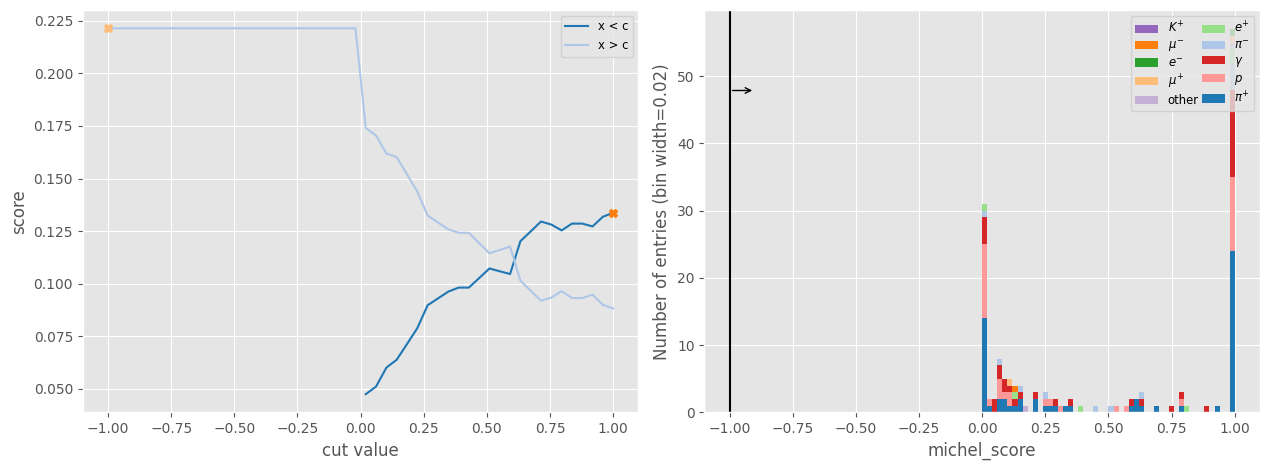

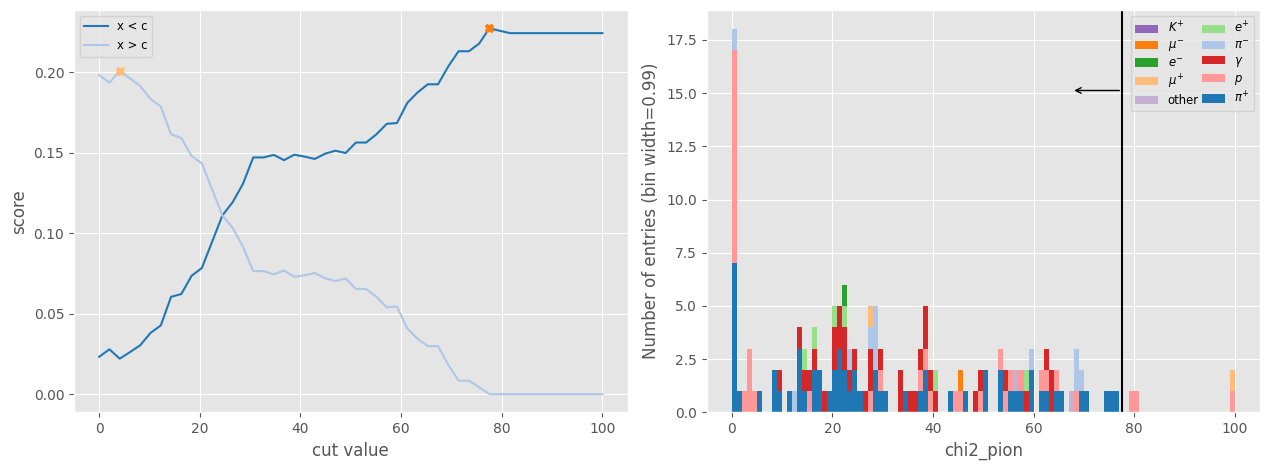

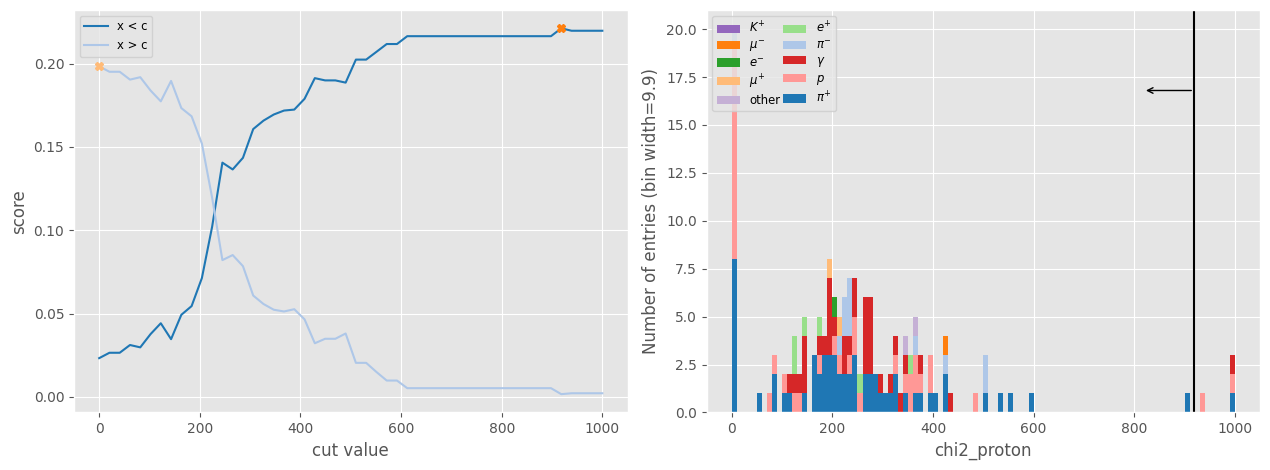

In [99]:


poor_pi_selection = {}

median_dEdX_cut, poor_pi_selection["median_dEdX"], median_dEdX_mask = CreateOptimisedSelection(observables["median_dEdX"][mask], p, x_range = ranges["median_dEdX"], invert = True)

track_score_cut, poor_pi_selection["track_score"], track_score_mask = CreateOptimisedSelection(observables["track_score"][mask], pi, x_range = ranges["track_score"], mask = median_dEdX_mask)

beam_ip_cut, poor_pi_selection["beam_ip"], beam_ip_mask = CreateOptimisedSelection(observables["beam_ip"][mask], pi, ranges["beam_ip"], mask = median_dEdX_mask & track_score_mask)

nHits_cut, poor_pi_selection["nHits"], nHits_cut = CreateOptimisedSelection(observables["nHits"][mask], pi, ranges["nHits"], mask = median_dEdX_mask & track_score_mask & beam_ip_mask)

# cut_op = CutOptimiser(observables["nHits_collection"][mask], gamma, x_range = ranges["nHits_collection"])
# nHits_collection_cut = cut_op.Optimise(cut_op.pe)
# nHits_collection_mask = ~SelectionTools.cuts_to_func(*nHits_collection_cut)(observables["nHits_collection"][mask])

# poor_pi_mask = beam_dist_mask & median_dEdX_mask & nHits_collection_mask


# cut_op = CutOptimiser(observables["median_dEdX"][mask], p, x_range = ranges["median_dEdX"])
# median_dEdX_cut = cut_op.Optimise(cut_op.pe)
# median_dEdX_mask = ~SelectionTools.cuts_to_func(*median_dEdX_cut)(observables["median_dEdX"][mask])

# cut_op = CutOptimiser(observables["beam_dist"][mask][median_dEdX_mask], pi[median_dEdX_mask], x_range = ranges["beam_dist"])
# beam_dist_cut = cut_op.Optimise(cut_op.pe)
# beam_dist_mask = SelectionTools.cuts_to_func(*beam_dist_cut)(observables["beam_dist"][mask])

# cut_op = CutOptimiser(observables["track_score"][mask][median_dEdX_mask & beam_dist_mask], gamma[median_dEdX_mask & beam_dist_mask], x_range = ranges["track_score"])
# track_score_cut = cut_op.Optimise(cut_op.pe)
# track_score_mask = ~SelectionTools.cuts_to_func(*track_score_cut)(observables["track_score"][mask])

poor_pi_mask = median_dEdX_mask & track_score_mask & beam_ip_mask & nHits_cut

tags_poor_pi = Tags.GenerateTrueParticleTags(mc_beam)

for t in tags_poor_pi:
    tags_poor_pi[t].mask = tags_poor_pi[t].mask[mask][poor_pi_mask]

Plots.PlotTags(tags_poor_pi)

cut_op = CutOptimiser(None, pi[poor_pi_mask])
for o in observables:
    cut_op.x = observables[o][mask][poor_pi_mask]
    cut_op.x_range = ranges[o]
    plot = Plots.MultiPlot(2)
    next(plot)
    results = cut_op.Optimise(cut_op.pe, plot = True)
    next(plot)
    cut_op.visualise(*results, tags = tags_poor_pi, x_label = o)

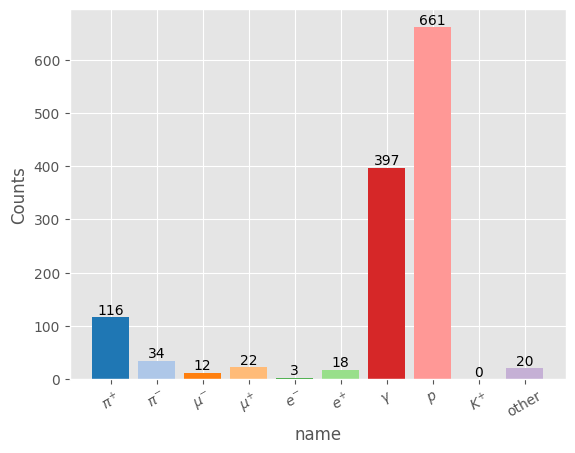

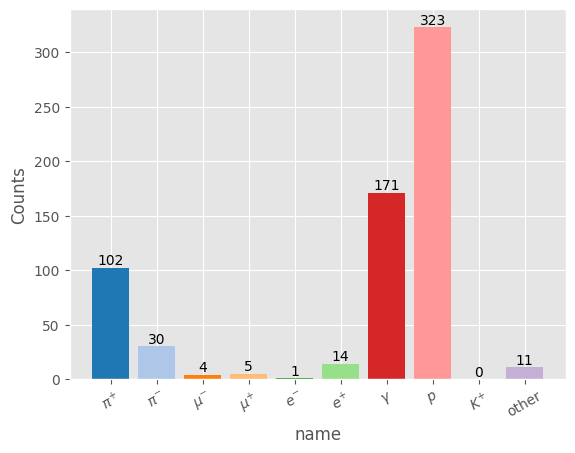

In [97]:
def visualise_tags(mask):
    tags = Tags.GenerateTrueParticleTags(mc_beam)
    for t in tags:
        tags[t].mask = tags[t].mask[mask]

    Plots.PlotTags(tags)



poor_pi_selection

remaining_PFOs = ~(pi_mask | photon_mask) #* PFOs which were not selected

remaining_PFOs_cex_region = remaining_PFOs & reco_regions["charge_exchange"]

visualise_tags(remaining_PFOs_cex_region)

masks = {}
for k, f in poor_pi_selection.items():
    masks[k] = f(observables[k]) & remaining_PFOs_cex_region

poor_pi_cex = SelectionTools.CombineMasks(masks)
visualise_tags(poor_pi_cex)

In [98]:
count_poor_pi = ak.sum(poor_pi_cex, -1)

for t in true_regions:
    found = ak.sum((count_poor_pi > 0) & true_regions[t])
    total = ak.sum(reco_regions["charge_exchange"] & true_regions[t])

    print(sum(reco_regions["charge_exchange"][count_poor_pi == 0]))

    print(t, found/total, total, total - found, total / sum(reco_regions["charge_exchange"]), (total - found) / sum(reco_regions["charge_exchange"][count_poor_pi == 0]))

189
absorption 0.6666666666666666 9 3 0.015517241379310345 0.015873015873015872
189
charge_exchange 0.5955056179775281 178 72 0.30689655172413793 0.38095238095238093
189
single_pion_production 0.6708860759493671 79 26 0.13620689655172413 0.13756613756613756
189
pion_production 0.7197452229299363 314 88 0.5413793103448276 0.4656084656084656


# Inspect confusion matrix

In [156]:
photon_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["photon"])
pi_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["pi"])
pi0_mask = SelectionTools.CombineMasks(args.selection_masks["mc"]["pi0"])

In [ ]:
for t in true_regions:

    cell = true_regions[t] & reco_regions["charge_exchange"]

    tags = Tags.GenerateTrueParticleTags(mc_beam)
    tags_t = Tags.Tags()
    for i in tags:
        tags_t[i] = tags[i]
        tags_t[i].mask = tags_t[i].mask & cell #& ~(photon_mask | pi_mask)
    Plots.PlotTags(tags_t, xlabel = "backtracked pdg")
    Plots.plt.title(t)
    
    # Plots.plt.figure()
    for _, i in Plots.IterMultiPlot([0, 1, 6, 7]):
        n = ak.sum(tags_t.number[i].mask, -1)
        Plots.PlotBar(n[n > 0], xlabel = tags_t.number[i].name, color = tags_t.number[i].colour, newFigure = False)

    Plots.plt.figure()
    plot = Plots.MultiPlot(2)
    next(plot)
    Plots.PlotBar(ak.sum(photon_mask[cell], -1), xlabel = "selected photons", newFigure = False)
    next(plot)
    Plots.PlotBar(ak.sum(pi_mask[cell], -1), xlabel = "selected pions", newFigure = False)
    # Plots.PlotBar(ak.num(mc_beam.trueParticlesBT.number, -1)[true_regions[t] & reco_regions["absorption"]])

    # Plots.PlotBar(mc_beam.trueParticles.nProton[true_regions[t]], xlabel = "number of true protons")
    # Plots.PlotBar(mc_beam.trueParticles.nPi0[true_regions[t]], xlabel = "number of true pi0s")
    # Plots.PlotBar(mc_beam.trueParticles.nPiMinus[true_regions[t]] + mc_beam.trueParticles.nPiPlus[true_regions[t]], xlabel = "number of true charged pi")


pdf confusion_matrices.pdf has been opened
pdf confusion_matrices.pdf has been closed
28587
28587
28587
21605
24511


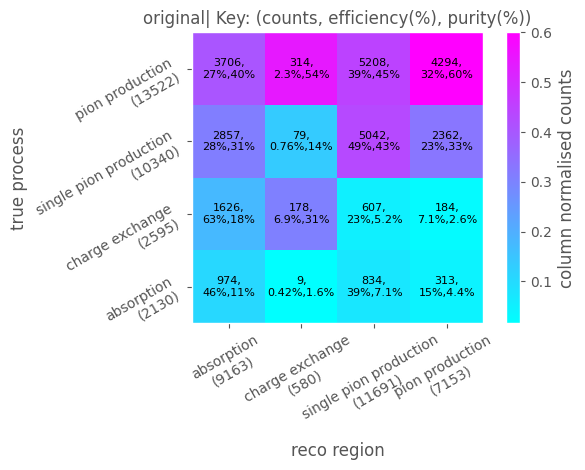

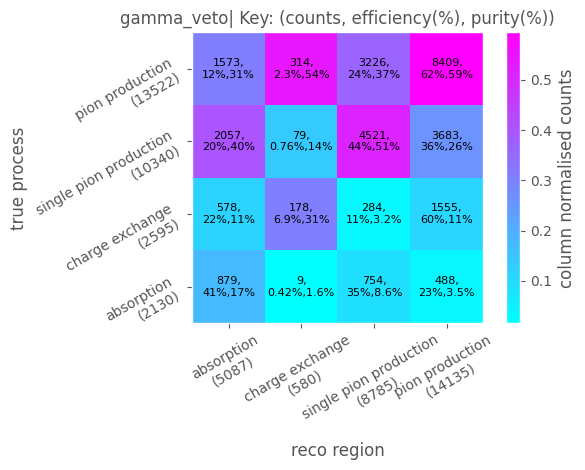

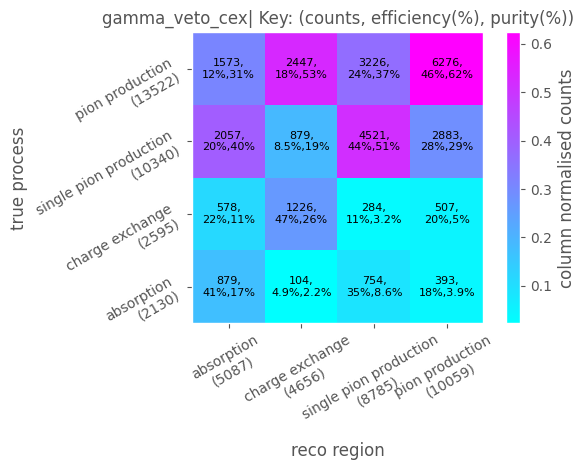

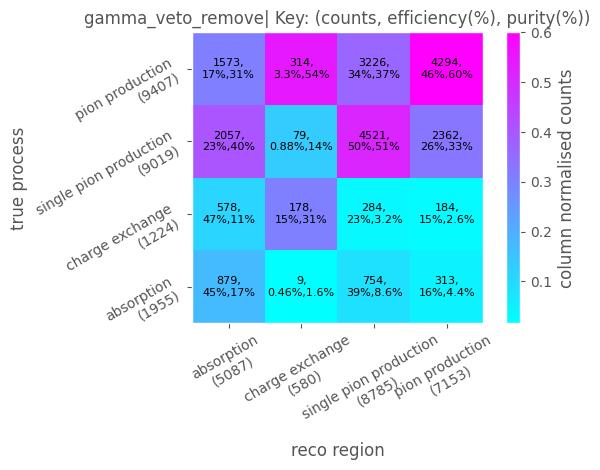

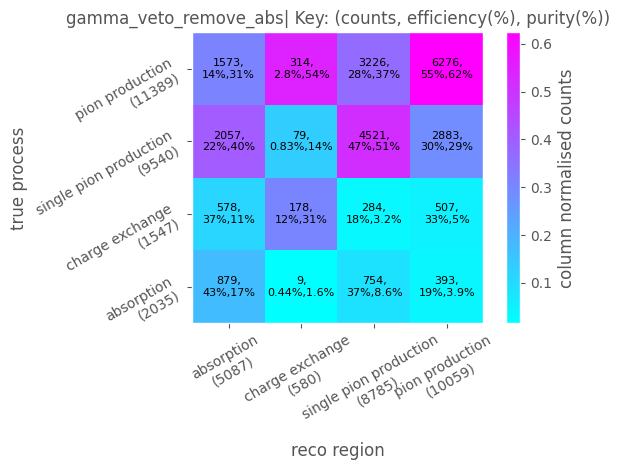

In [177]:
def create_regions_gamma_veto_cex(pi0_counts, pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts == 0),
        "charge_exchange": (pi0_counts == 1) & (pi_charged_counts == 0) | ((pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts > 0)),
        "single_pion_production": np.logical_and(np.logical_and(pi0_counts==0, pi_charged_counts==1), photon_counts == 0),
        "pion_production": ((pi0_counts >= 0) & (pi_charged_counts > 1)) | ((pi0_counts > 1) & (pi_charged_counts >= 0)) | ((pi0_counts == 1) & (pi_charged_counts == 1)) | ((pi0_counts == 0) & (pi_charged_counts == 1) & (photon_counts > 0)),
    }
    return regions_dict

def create_regions_gamma_veto(pi0_counts, pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts == 0),
        "charge_exchange": (pi0_counts == 1) & (pi_charged_counts == 0),
        "single_pion_production": np.logical_and(np.logical_and(pi0_counts==0, pi_charged_counts==1), photon_counts == 0),
        "pion_production": ((pi0_counts >= 0) & (pi_charged_counts > 1)) | ((pi0_counts > 1) & (pi_charged_counts >= 0)) | ((pi0_counts == 1) & (pi_charged_counts == 1)) | ((pi0_counts == 0) & (pi_charged_counts <= 1) & (photon_counts > 0)),
    }
    return regions_dict

def create_gamma_veto_no_migration(pi0_counts, pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts == 0),
        "charge_exchange": (pi0_counts == 1) & (pi_charged_counts == 0),
        "single_pion_production": (pi0_counts == 0) & (pi_charged_counts == 1) & (photon_counts == 0),
        "pion_production": ((pi0_counts >= 0) & (pi_charged_counts > 1)) | ((pi0_counts > 1) & (pi_charged_counts >= 0))| ((pi0_counts == 1) & (pi_charged_counts == 1)),
    }
    return regions_dict

def create_gamma_veto_no_migration_cex(pi0_counts, pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi0_counts == 0) & (pi_charged_counts == 0) & (photon_counts == 0),
        "charge_exchange": (pi0_counts == 1) & (pi_charged_counts == 0),
        "single_pion_production": (pi0_counts == 0) & (pi_charged_counts == 1) & (photon_counts == 0),
        "pion_production": ((pi0_counts >= 0) & (pi_charged_counts > 1)) | ((pi0_counts > 1) & (pi_charged_counts >= 0)) | ((pi0_counts == 1) & (pi_charged_counts == 1)) | ((pi0_counts == 0) & (pi_charged_counts == 1) & (photon_counts > 0)),
    }
    return regions_dict

def create_regions_no_pi0(pi_charged_counts, photon_counts):
    regions_dict = {
        "absorption": (pi_charged_counts == 0) & (photon_counts < 1),
        "charge_exchange": (photon_counts > 1) & (pi_charged_counts == 0),
        "single_pion_production": (pi_charged_counts == 1) & (photon_counts < 1),
    }
    regions_dict["pion_production"] = ~(regions_dict["absorption"] | regions_dict["charge_exchange"] | regions_dict["single_pion_production"])
    return regions_dict


n_pi =  SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi"])
n_pi0 = SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])
n_photon = SelectionTools.GetPFOCounts(args.selection_masks["mc"]["photon"])

reco_region_methods = {
    "original" : reco_regions,
    "gamma_veto" : create_regions_gamma_veto(n_pi0, n_pi, n_photon),
    "gamma_veto_cex" : create_regions_gamma_veto_cex(n_pi0, n_pi, n_photon),
    "gamma_veto_remove" : create_gamma_veto_no_migration(n_pi0, n_pi, n_photon),
    "gamma_veto_remove_abs" : create_gamma_veto_no_migration_cex(n_pi0, n_pi, n_photon)
}

counts = {r : cross_section.Toy.ComputeCounts(true_regions, reco_region_methods[r]) for r in reco_region_methods}

# counts_no_pi0 = cross_section.Toy.ComputeCounts(true_regions, reco_regions_no_pi0)

with Plots.PlotBook("confusion_matrices", True) as book:
    for i in counts:
        Plots.PlotConfusionMatrix(counts[i], list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region", title = i)
        book.Save()

    # Plots.PlotConfusionMatrix(counts_nominal, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")
    # Plots.PlotConfusionMatrix(counts_op, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")
    # book.Save()

# Plots.PlotConfusionMatrix(counts_no_pi0, list(reco_regions.keys()), list(true_regions.keys()), y_label = "true process", x_label = "reco region")
for i in counts:
    print(np.sum(counts[i]))

In [178]:
beam_pi0 = (mc_beam.trueParticles.pdg == 111) & (mc_beam.trueParticles.mother == 1)

photon_mothers = np.where(mc_beam.trueParticles.pdg == 22, mc_beam.trueParticles.mother, 0)

beam_pi0_photon = []

for i, j in zip(photon_mothers, mc_beam.trueParticles.number[beam_pi0]):
    if len(j) == 0:
        beam_pi0_photon.append(np.zeros_like(i, dtype = bool))
    else:
        beam_pi0_photon.append(ak.any([i == k for k in j], 0))
beam_pi0_photon = ak.Array(beam_pi0_photon)


In [179]:
true_pi_mask = (mc_beam.trueParticles.pdg == 211) | (mc_beam.trueParticles.pdg == -211)

true_proton_mask = mc_beam.trueParticles.pdg == 2212
true_neutron_mask = mc_beam.trueParticles.pdg == 2112

true_non_beam_mask = mc_beam.trueParticles.number != 1

true_beam_daughter = mc_beam.trueParticles.mother == 1

true_gamma_mask = mc_beam.trueParticles.pdg == 22

true_pi0_mask = mc_beam.trueParticles.pdg == 111

In [180]:
mom_mag = vector.magnitude(mc_beam.trueParticles.momentum)
dist = vector.dist(mc_beam.trueParticles.endPos, mc_beam.trueParticles.start_pos)
ke = cross_section.KE(mom_mag, mc_beam.trueParticles.mass)

mean_dEdX = ke / dist

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


In [181]:
def TrueBeamDaughterTags(process : str = None):
    true_particle_tags = Tags.Tags()

    for t in [
        Tags.Tag(name = f"${cross_section.Particle.from_pdgid(2212).latex_name}$", name_simple = "p", number = 0, colour = "C0", mask = true_non_beam_mask & true_proton_mask & true_beam_daughter),
        Tags.Tag(name = f"${cross_section.Particle.from_pdgid(2112).latex_name}$", name_simple = "n", number = 1, colour = "C1", mask = true_non_beam_mask & true_neutron_mask & true_beam_daughter),
        Tags.Tag(name = f"${cross_section.Particle.from_pdgid(22).latex_name}$", name_simple = "gamma", number = 2, colour = "C2", mask = true_non_beam_mask & true_gamma_mask & beam_pi0_photon),
        Tags.Tag(name = "$\pi^{\pm}$", name_simple = "pi", number = 3, colour = "C3", mask = true_non_beam_mask & true_pi_mask & true_beam_daughter),
        Tags.Tag(name = f"${cross_section.Particle.from_pdgid(111).latex_name}$", name_simple = "pi0", number = 4, colour = "C4", mask = true_non_beam_mask & true_pi0_mask & true_beam_daughter)
    ]: true_particle_tags[t.name_simple] = t
    
    if process is not None:
        for t in true_particle_tags:
            true_particle_tags[t].mask = true_particle_tags[t].mask & true_regions[process]

    return true_particle_tags

In [182]:
book = Plots.PlotBook("true_kinematics_2GeV.pdf", False)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


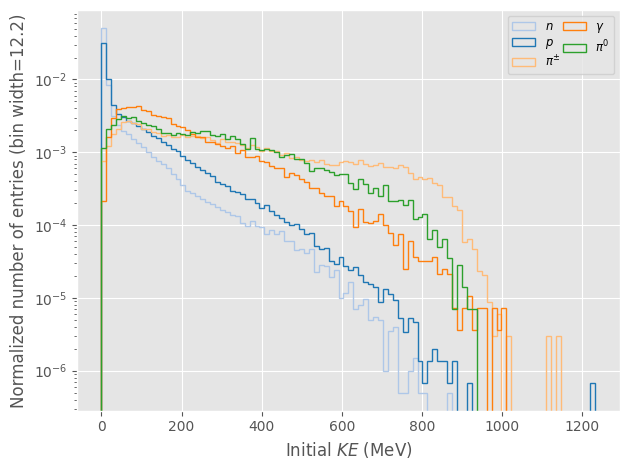

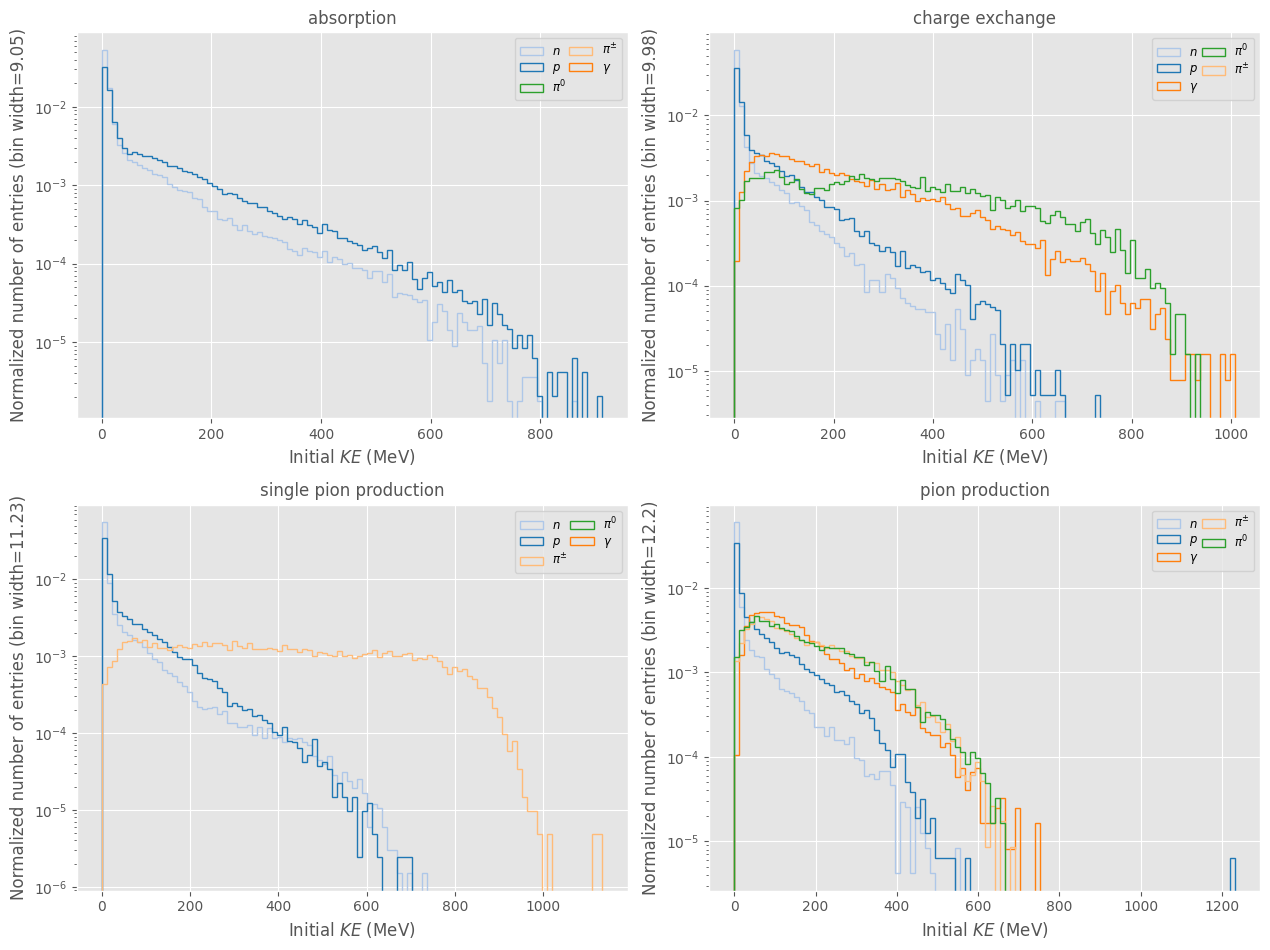

In [22]:
Plots.PlotTagged(ke, TrueBeamDaughterTags(), y_scale = "log", stacked = False, reverse_sort = True, histtype = "step", x_label = "Initial $KE$ (MeV)", norm = True)
book.Save()

for _, t in Plots.IterMultiPlot(true_regions):
    Plots.PlotTagged(ke, TrueBeamDaughterTags(t), y_scale = "log", stacked = False, reverse_sort = True, histtype = "step", x_label = "Initial $KE$ (MeV)", norm = True, newFigure = False, title = cross_section.remove_(t))
book.Save()

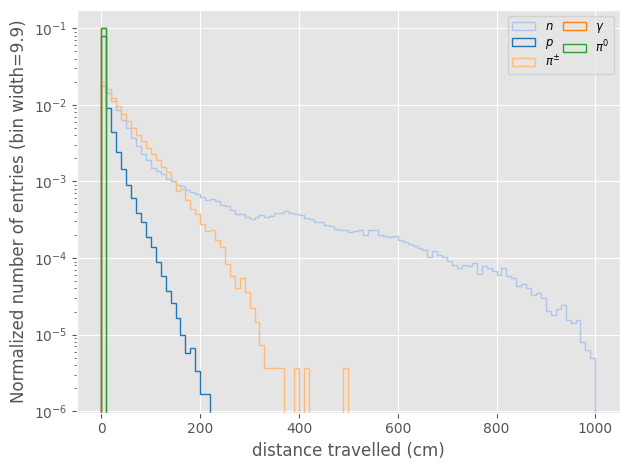

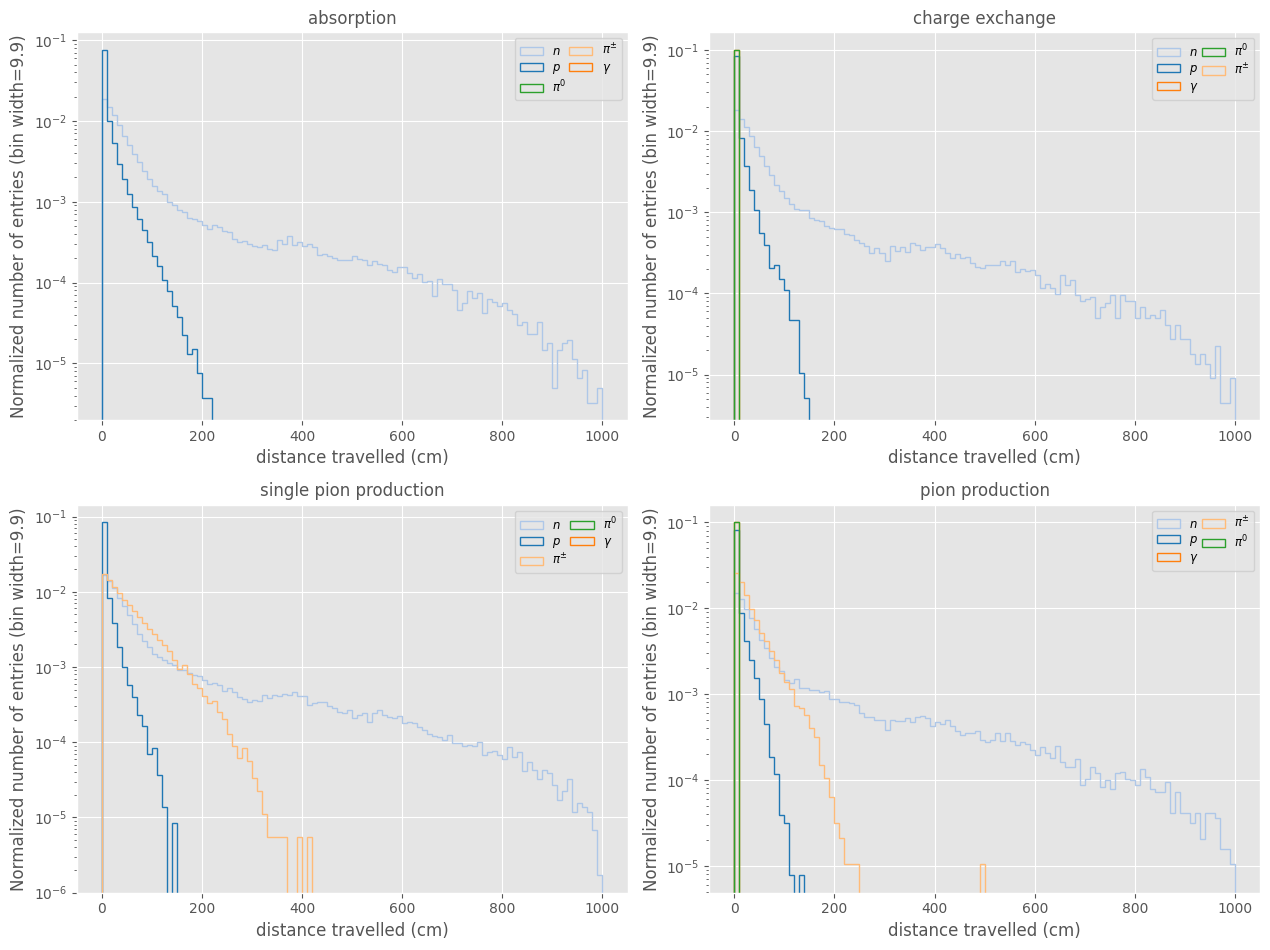

In [23]:
Plots.PlotTagged(dist, TrueBeamDaughterTags(), y_scale = "log", stacked = False, reverse_sort = True, histtype = "step", x_range = [0, 1000], norm = True, x_label = "distance travelled (cm)")
book.Save()
for _, t in Plots.IterMultiPlot(true_regions):
    Plots.PlotTagged(dist, TrueBeamDaughterTags(t), y_scale = "log", stacked = False, reverse_sort = True, histtype = "step", x_label = "distance travelled (cm)", norm = True, newFigure = False, title = cross_section.remove_(t), x_range = [0, 1000])
book.Save()


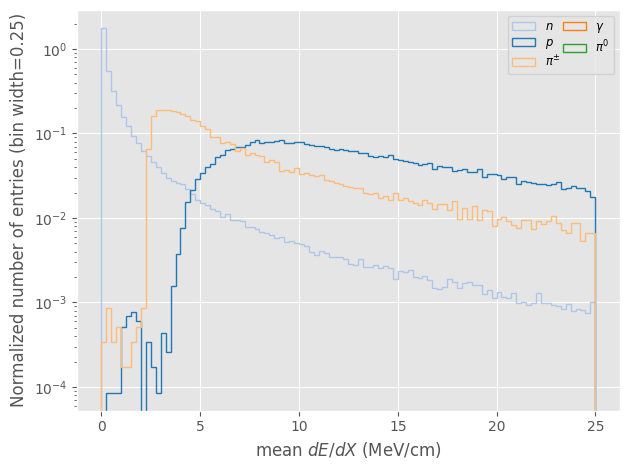

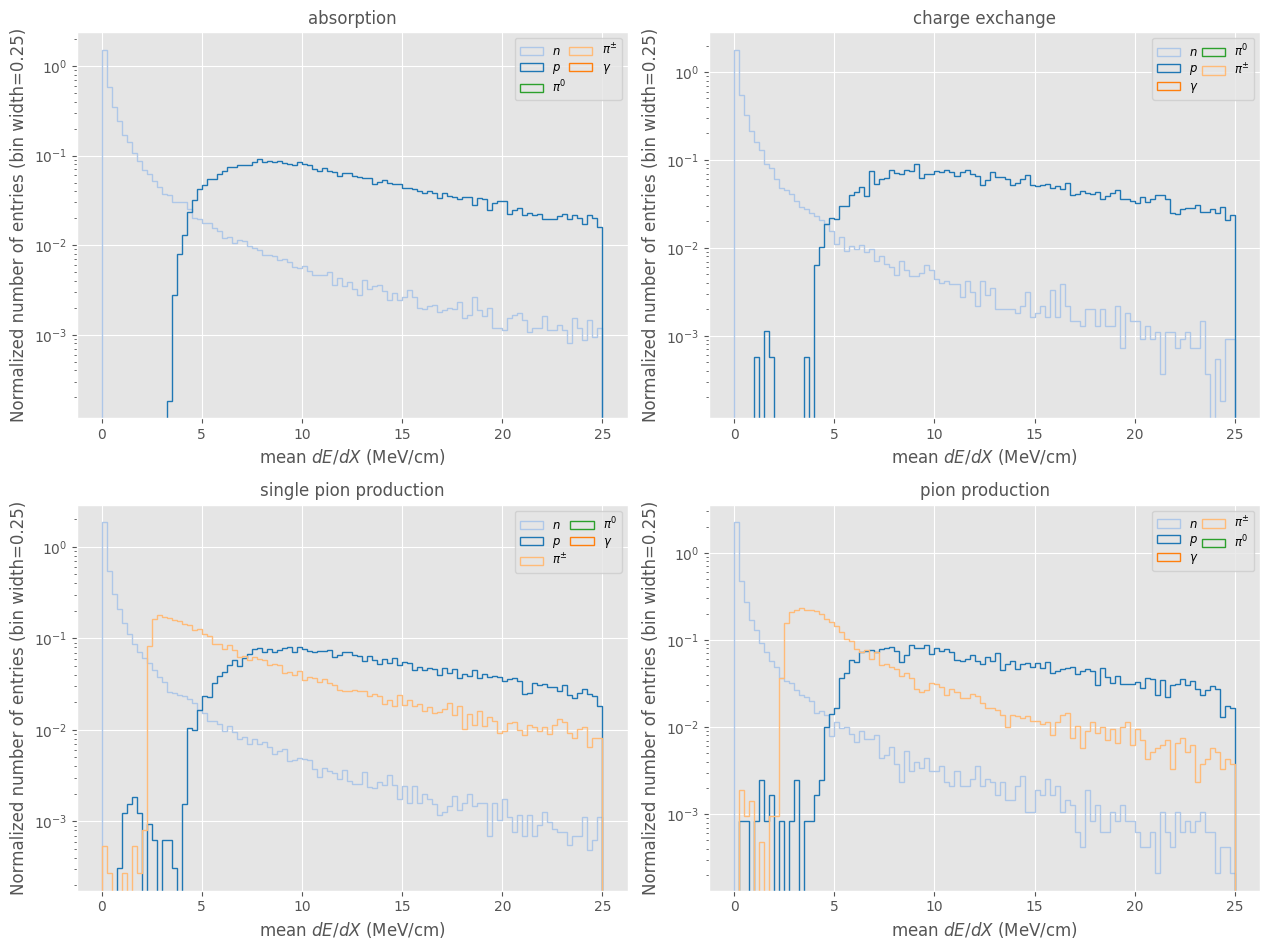

In [24]:
Plots.PlotTagged(mean_dEdX, TrueBeamDaughterTags(), y_scale = "log", stacked = False, reverse_sort = True, x_range = [0, 25], histtype = "step", norm = True, x_label = "mean $dE/dX$ (MeV/cm)")
book.Save()

for _, t in Plots.IterMultiPlot(true_regions):
    Plots.PlotTagged(mean_dEdX, TrueBeamDaughterTags(t), y_scale = "log", stacked = False, reverse_sort = True, histtype = "step", x_label = "mean $dE/dX$ (MeV/cm)", norm = True, newFigure = False, title = cross_section.remove_(t), x_range = [0, 25])
book.Save()


pdf true_kinematics_1GeV.pdf has been closed


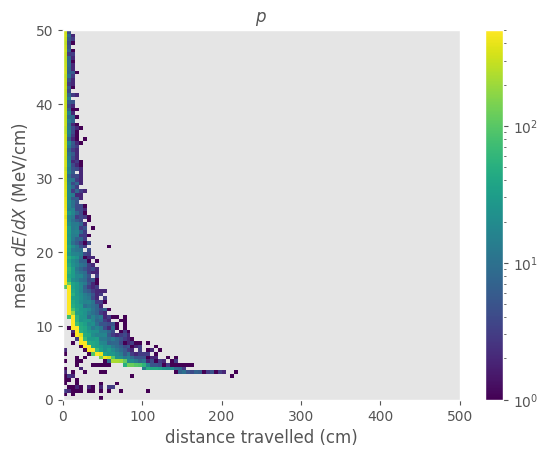

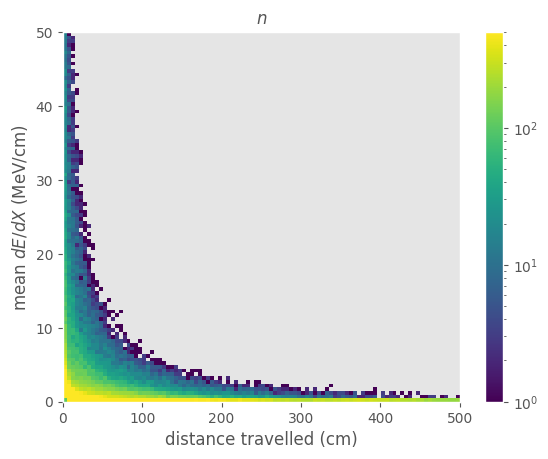

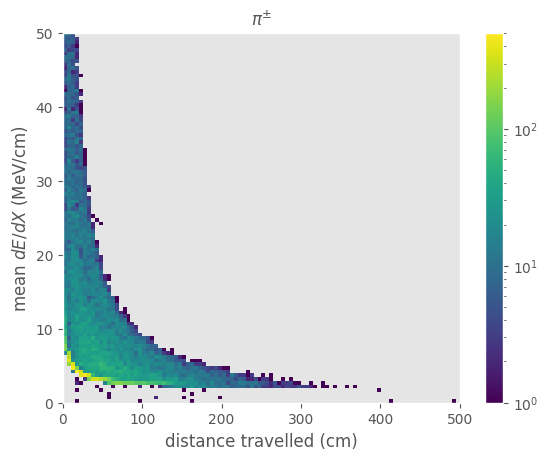

In [25]:
# Plots.PlotHist2D(ak.ravel(dist), ak.ravel(mean_dEdX), x_range = [0, 500], y_range = [0, 50])
for t in TrueBeamDaughterTags().values():
    if t.name_simple in ["gamma", "pi0"]: continue

    Plots.PlotHist2DImshow(ak.ravel(dist[t.mask]), ak.ravel(mean_dEdX[t.mask]), x_range = [0, 500], y_range = [0, 50], title = t.name, xlabel = "distance travelled (cm)", ylabel = "mean $dE/dX$ (MeV/cm)", c_range = [1, 500], c_scale = "log")
    book.Save()
book.close()

In [205]:
def MakeParticleCounts(region : str = None, process : str = None):

    if region is not None:
        rr = reco_regions[region]
    else:
        rr = np.ones_like(mc_beam.eventNum, dtype = bool)

    if process is not None:
        tr = true_regions[process]
    else:
        tr = np.ones_like(mc_beam.eventNum, dtype = bool)

    nParticles = {
        "pi" : ak.num(mc_beam.trueParticles.pdg[true_non_beam_mask & true_pi_mask & true_beam_daughter], -1)[tr & rr],
        "gamma" : ak.num(mc_beam.trueParticles.pdg[true_non_beam_mask & true_gamma_mask & beam_pi0_photon], -1)[tr & rr],
        "pi0" : ak.num(mc_beam.trueParticles.pdg[true_non_beam_mask & true_pi0_mask & true_beam_daughter], -1)[tr & rr],
        "proton" : ak.num(mc_beam.trueParticles.pdg[true_non_beam_mask & true_proton_mask & true_beam_daughter], -1)[tr & rr],
        "neutron" : ak.num(mc_beam.trueParticles.pdg[true_non_beam_mask & true_neutron_mask & true_beam_daughter], -1)[tr & rr]

    }

    # nPFOs = ak.num(mc_beam.trueParticlesBT.pdg[mc_beam.trueParticlesBT.pdg == 211], -1)

    nSelectedParticles = {
        "pi" : ak.sum(tr & pi_mask, -1)[tr & rr],
        "gamma" : ak.sum(tr & photon_mask, -1)[tr & rr],
        "pi0" : ak.sum(tr & pi0_mask, -1)[tr & rr]
    }
    return nParticles, nSelectedParticles

def CreateMatrix(x, y):
    mat = np.zeros([max(x) + 1, max(y) + 1])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            mat[i, j] = sum((x == i) & (y == j))
    return mat

def CreateMatrix3D(x, y, z):
    mat = np.zeros([max(x) + 1, max(y) + 1, max(z) + 1])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            for k in range(mat.shape[2]):
                mat[i, j, k] = sum((x == i) & (y == j) & (z == k))
    return mat

def PlotMat(mat, x_label, y_label, title : str = None, newFigure = True):
    if newFigure is True: Plots.plt.figure()
    Plots.plt.imshow(mat, origin = "lower", cmap = "cool")
    Plots.plt.xlabel(x_label)
    Plots.plt.ylabel(y_label)
    Plots.plt.grid(False)
    Plots.plt.title(title)

    for (i, j), z in np.ndenumerate(mat):
        Plots.plt.text(j, i, int(z), ha='center', va='center', weight = "bold")
    # Plots.plt.tight_layout()
    return

labels = {"pi" : "$\pi^{\pm}$", "gamma" : "$\gamma$", "pi0" : "$\pi^{0}$", "proton" : "$p$", "neutron" : "n"}


{'pi': <Array [1, 1, 1, 0, 3, 0, ... 1, 2, 0, 0, 0, 0] type='314 * int64'>, 'gamma': <Array [2, 2, 2, 4, 0, 4, ... 2, 4, 4, 6, 4, 4] type='314 * int64'>, 'pi0': <Array [1, 1, 1, 2, 0, 2, ... 1, 2, 2, 3, 2, 2] type='314 * int64'>, 'proton': <Array [9, 2, 1, 3, 1, 3, ... 2, 2, 6, 4, 1, 4] type='314 * int64'>, 'neutron': <Array [10, 2, 4, 5, 1, 4, ... 1, 8, 5, 1, 6] type='314 * int64'>}
{'pi': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='314 * int64'>, 'gamma': <Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='314 * int64'>, 'pi0': <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='314 * int64'>}


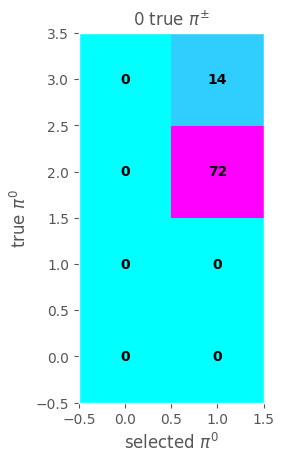

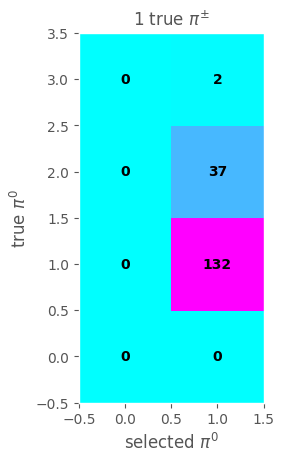

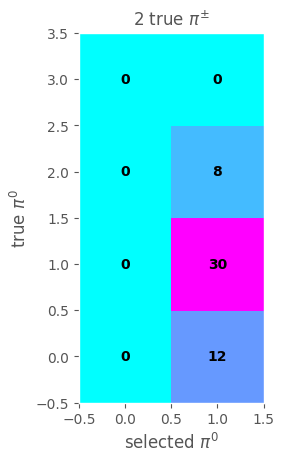

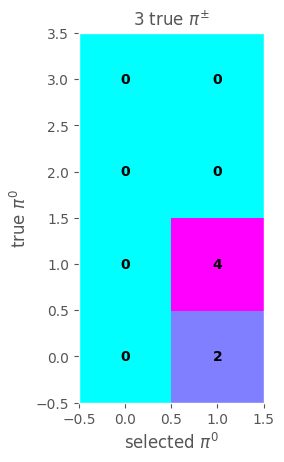

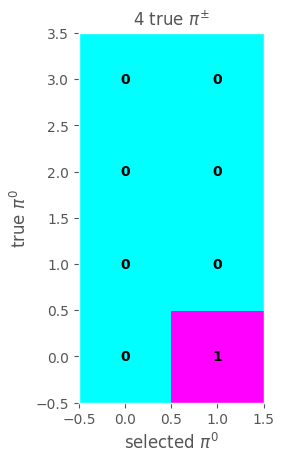

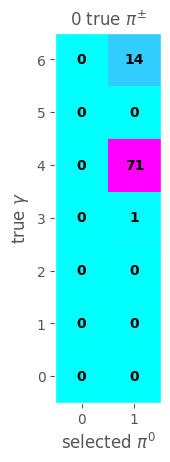

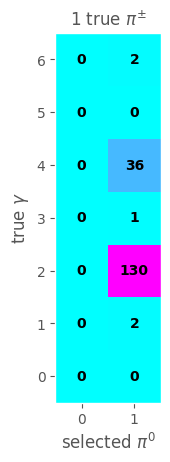

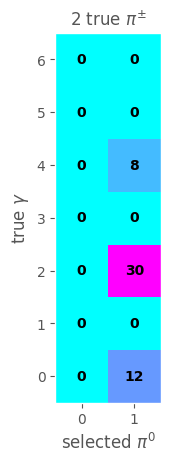

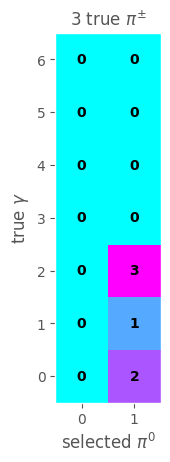

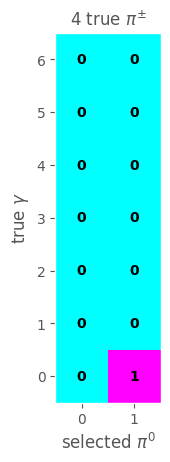

In [231]:
true_counts, reco_counts = MakeParticleCounts("charge_exchange", "pion_production")

print(true_counts)
print(reco_counts)

# PlotMat(CreateMatrix(true_counts["pi"], true_counts["pi0"]), "true pi0", "true pi")

d = CreateMatrix3D(true_counts["pi"], true_counts["pi0"], reco_counts["pi0"])

for m in range(d.shape[0]):
    PlotMat(d[m, :, :], "selected $\pi^{0}$", "true $\pi^{0}$", title = f"{m} true $\pi^{{\pm}}$")


d = CreateMatrix3D(true_counts["pi"], true_counts["gamma"], reco_counts["pi0"])

for m in range(d.shape[0]):
    PlotMat(d[m, :, :], "selected $\pi^{0}$", "true $\gamma$", title = f"{m} true $\pi^{{\pm}}$")


# PlotMat(CreateMatrix(reco_counts["pi"], true_counts["pi0"]), "true pi0", "reco pi")
# PlotMat(CreateMatrix(true_counts["pi"], reco_counts["pi0"]), "reco pi0", "true pi")
# PlotMat(CreateMatrix(reco_counts["pi"], reco_counts["pi0"]), "reco pi0", "reco pi")

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


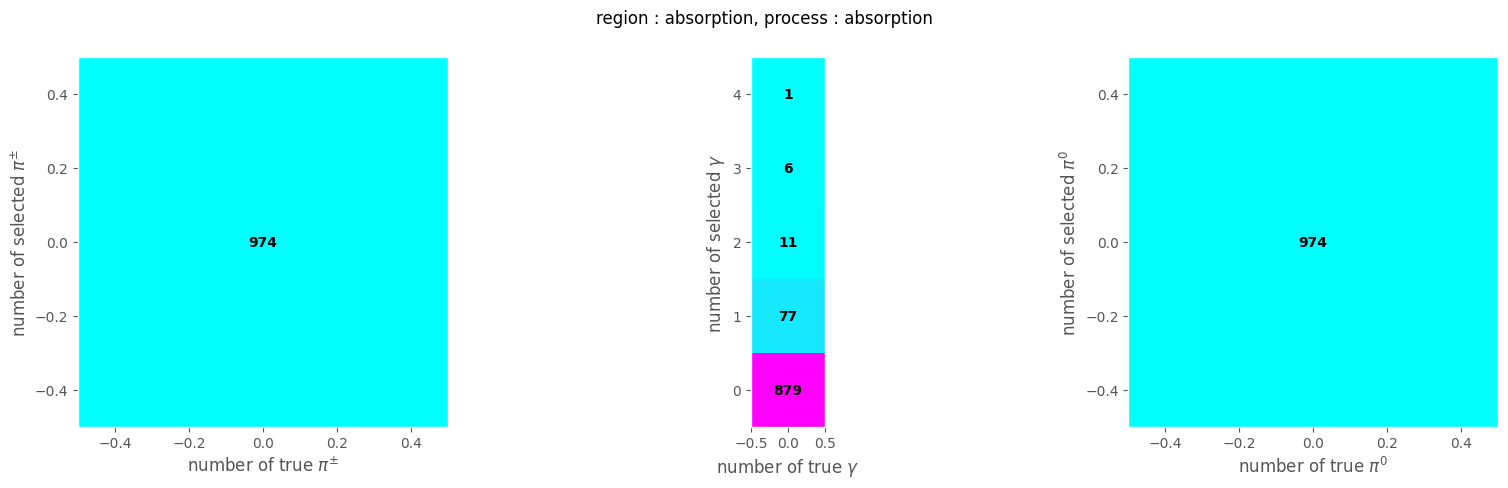

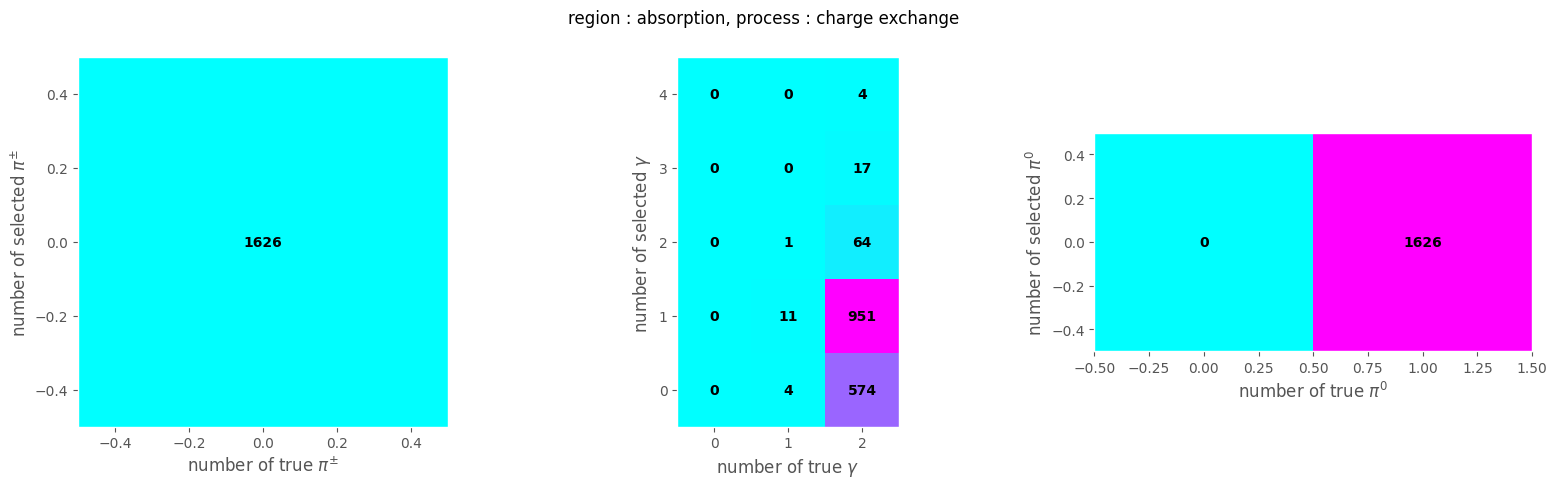

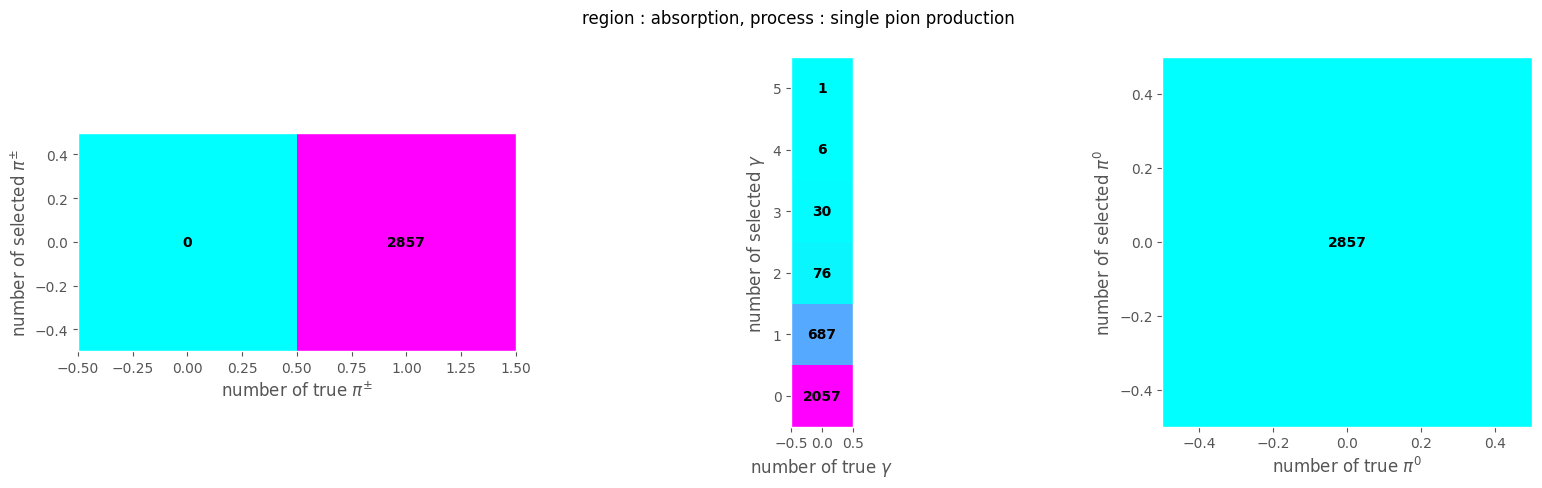

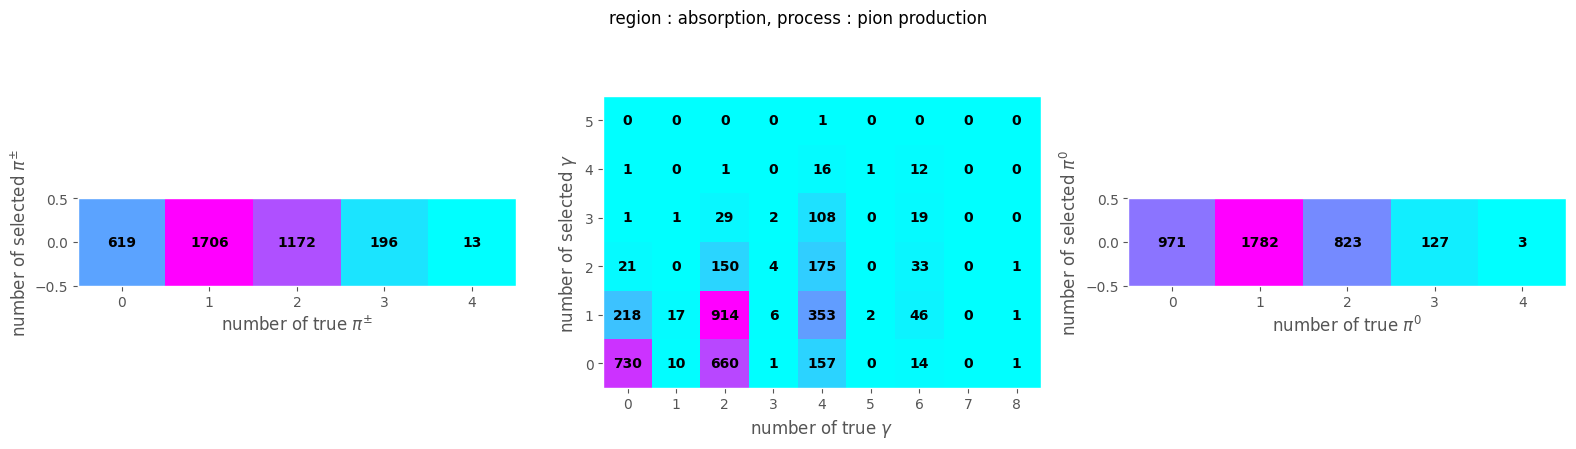

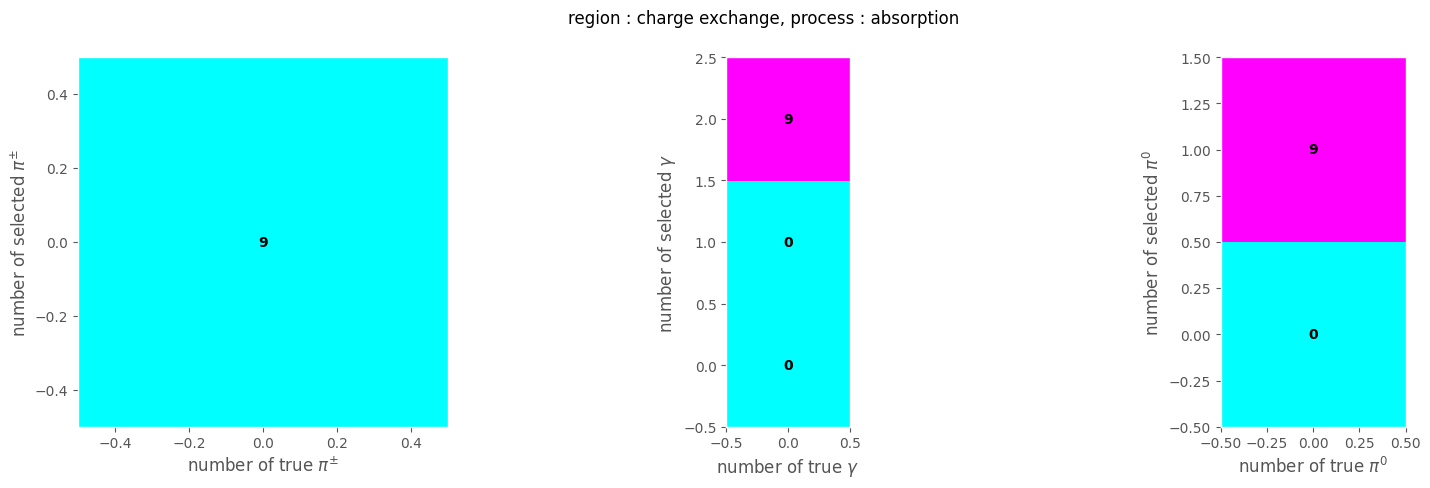

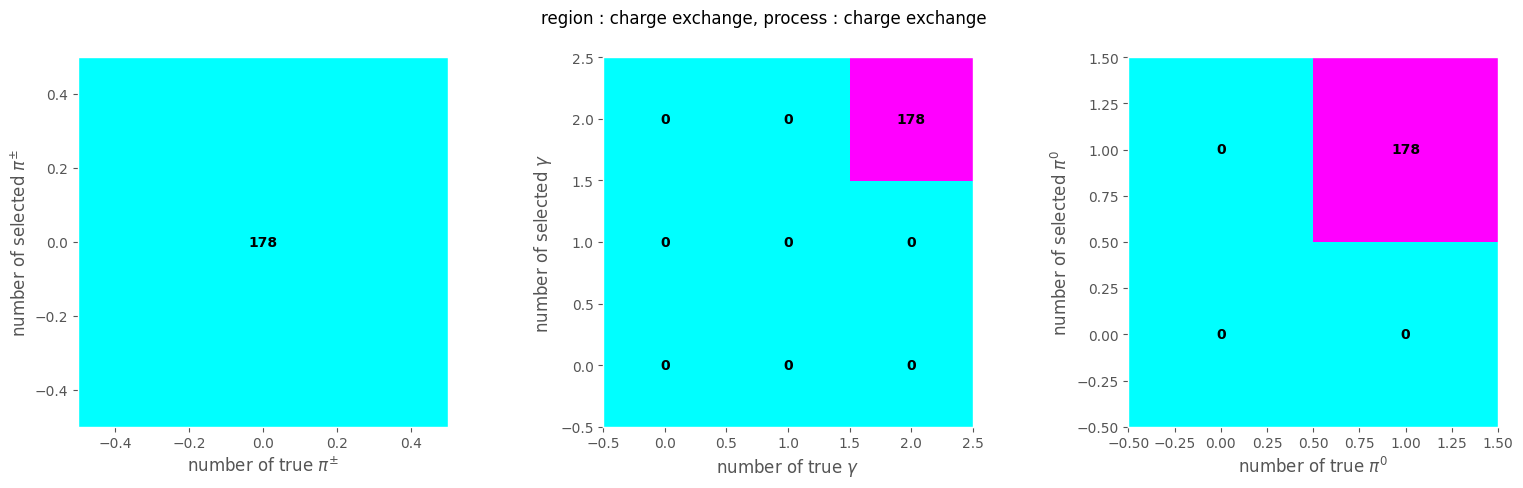

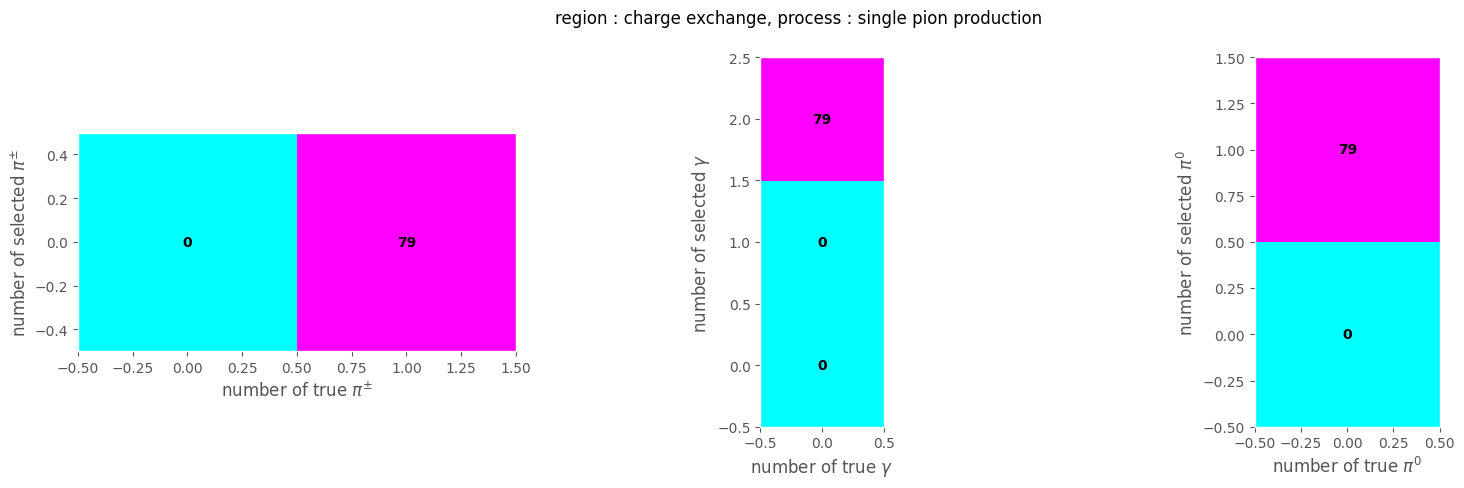

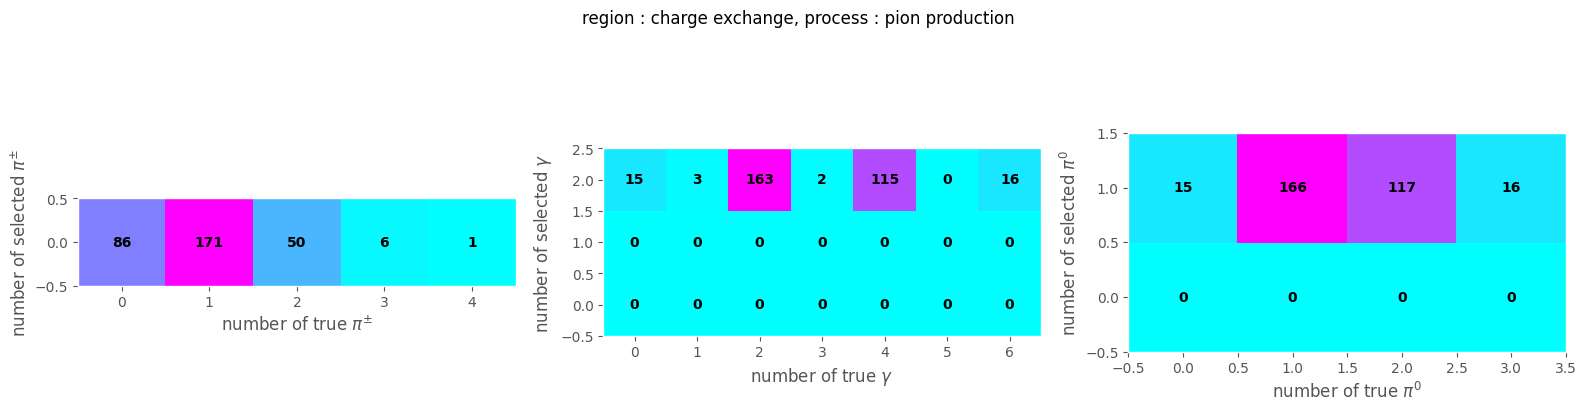

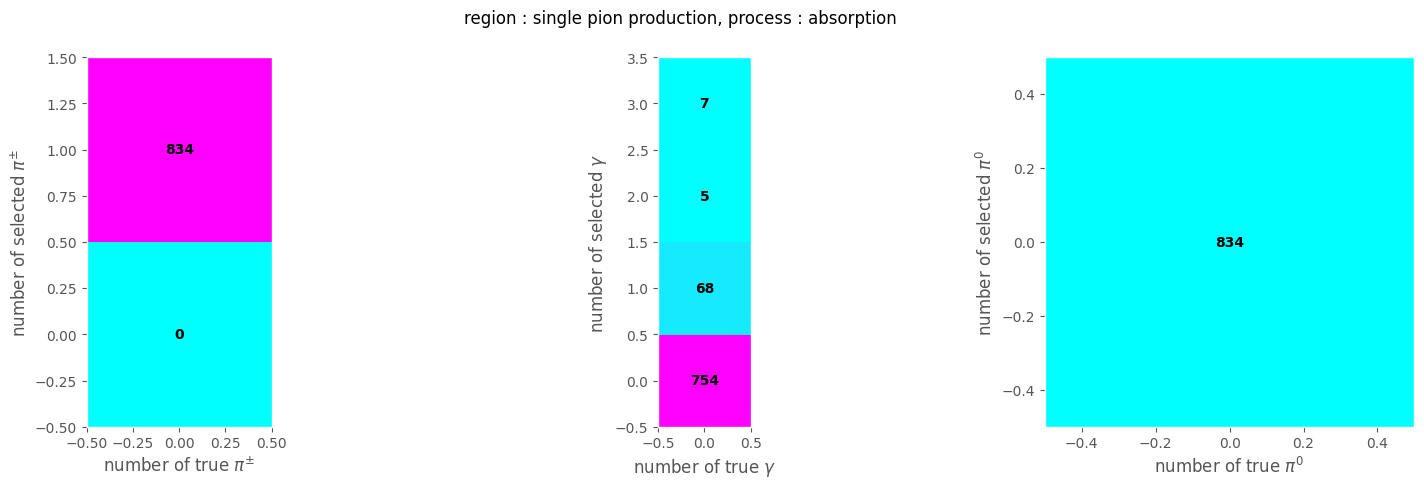

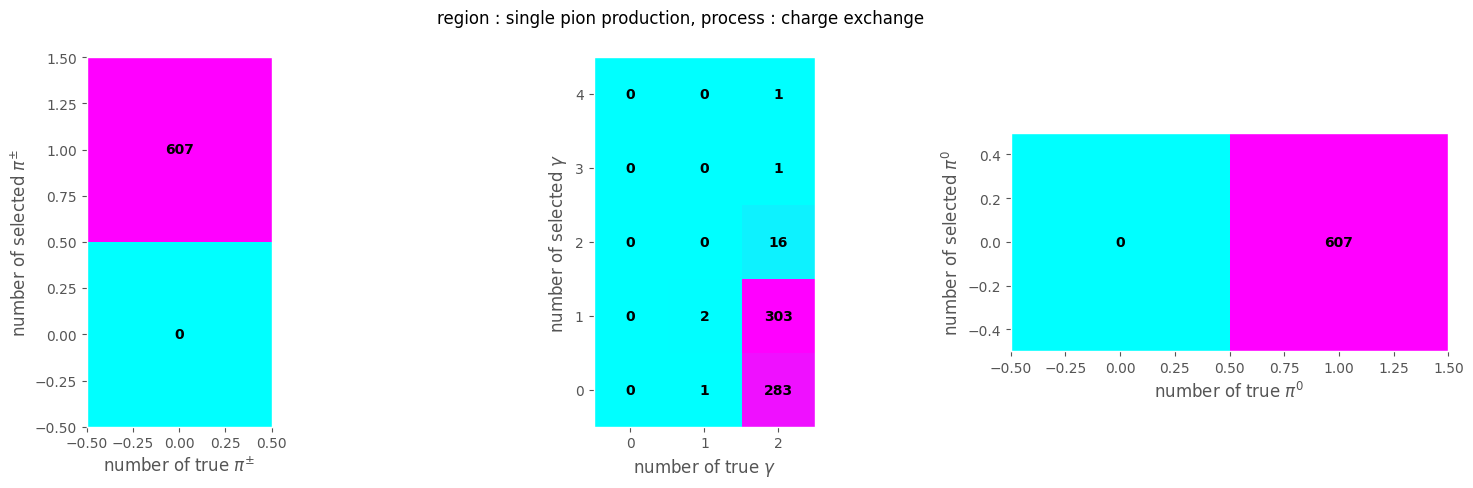

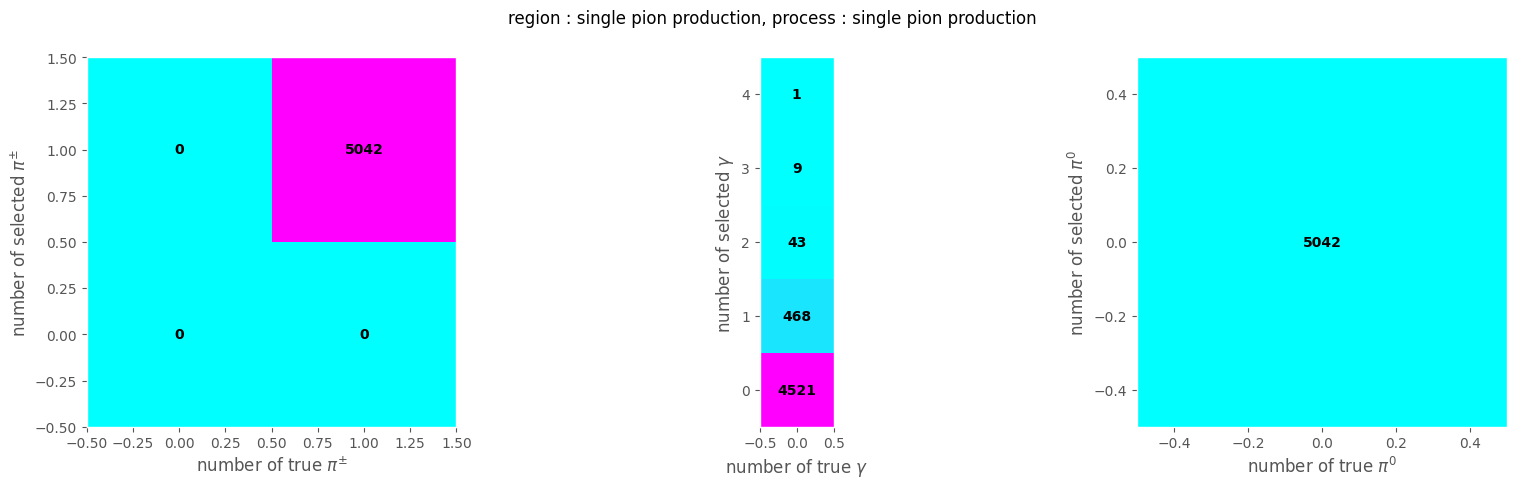

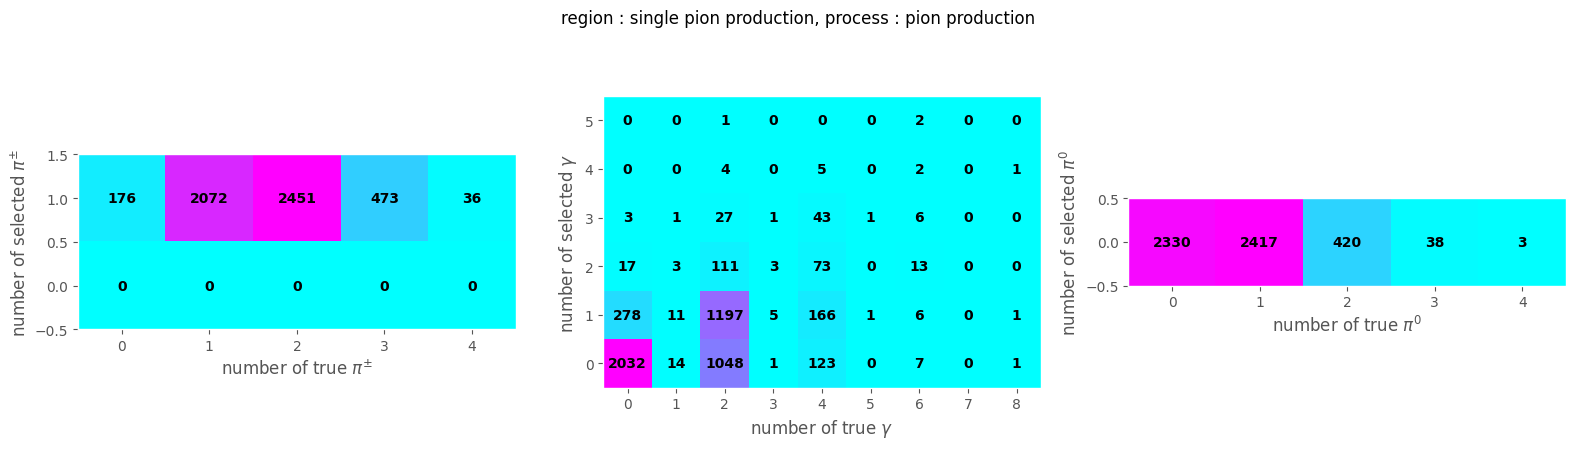

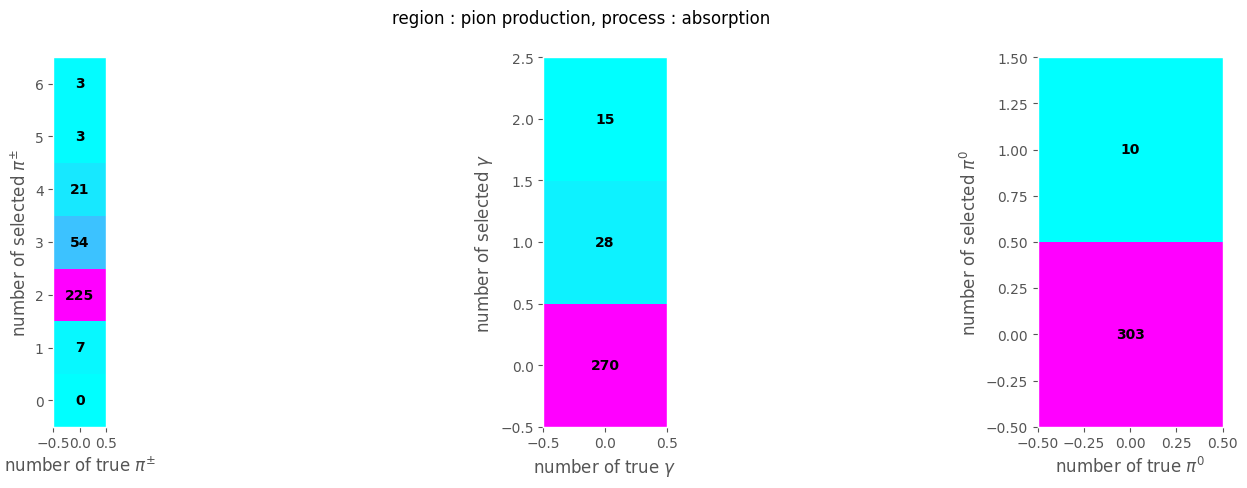

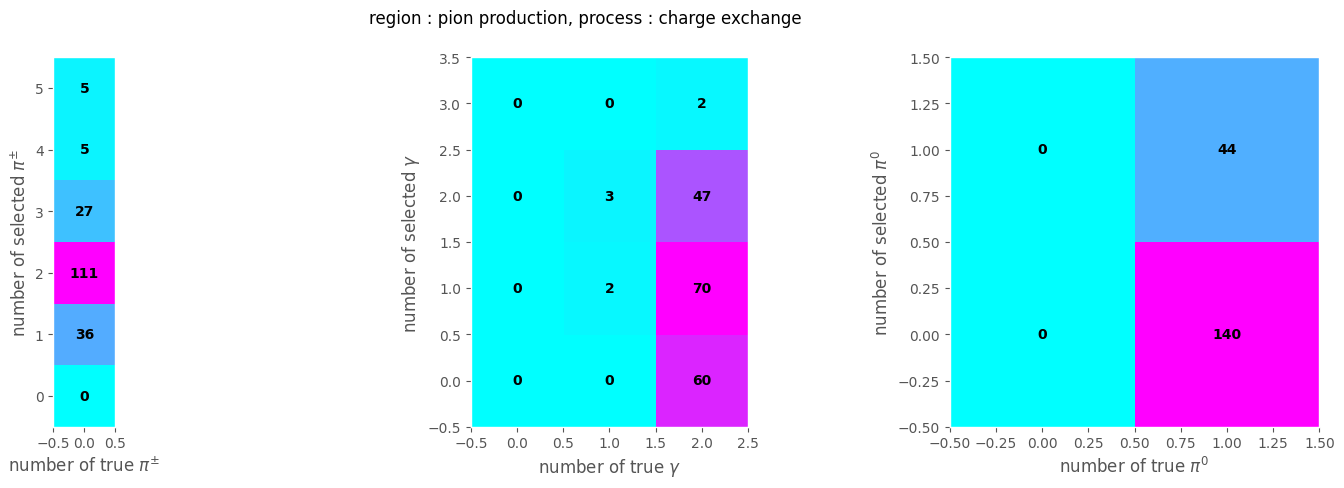

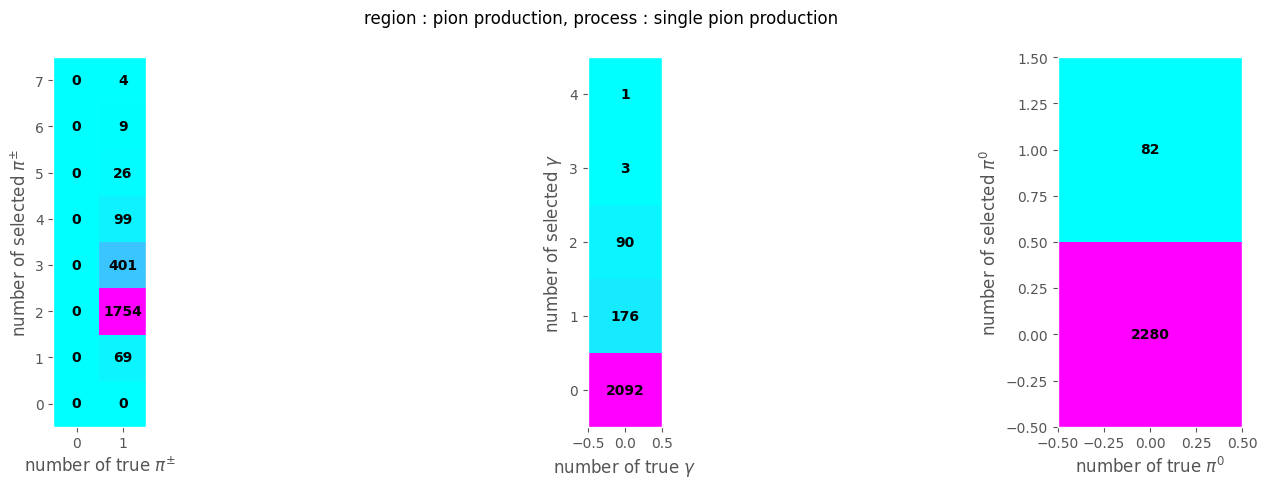

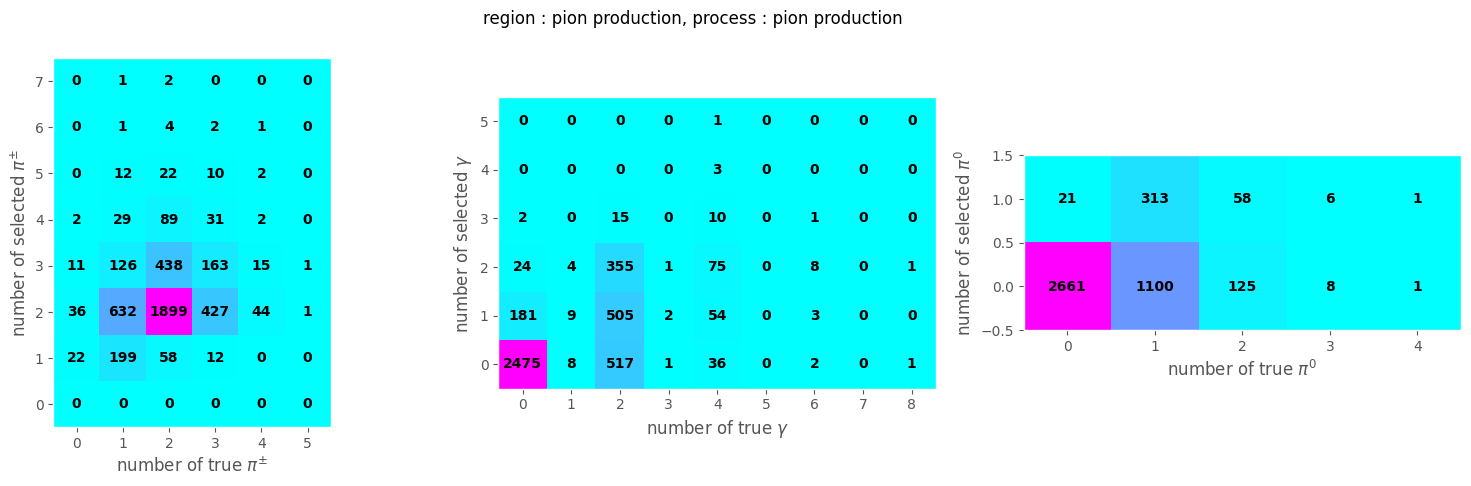

In [184]:
with Plots.PlotBook("event_topologies_2GeV.pdf", False) as book:
    for r in reco_regions:
        for t in true_regions:
            true_counts, reco_counts = MakeParticleCounts(r, t)

            mats = {k : CreateMatrix(reco_counts[k], true_counts[k]) for k in reco_counts}

            title = f"region : {cross_section.remove_(r)}, process : {cross_section.remove_(t)}"

            for _, k in Plots.IterMultiPlot(mats):
                Plots.plt.suptitle(title)
                PlotMat(mats[k], f"number of true {labels[k]}", f"number of selected {labels[k]}", None, newFigure = False)
            book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


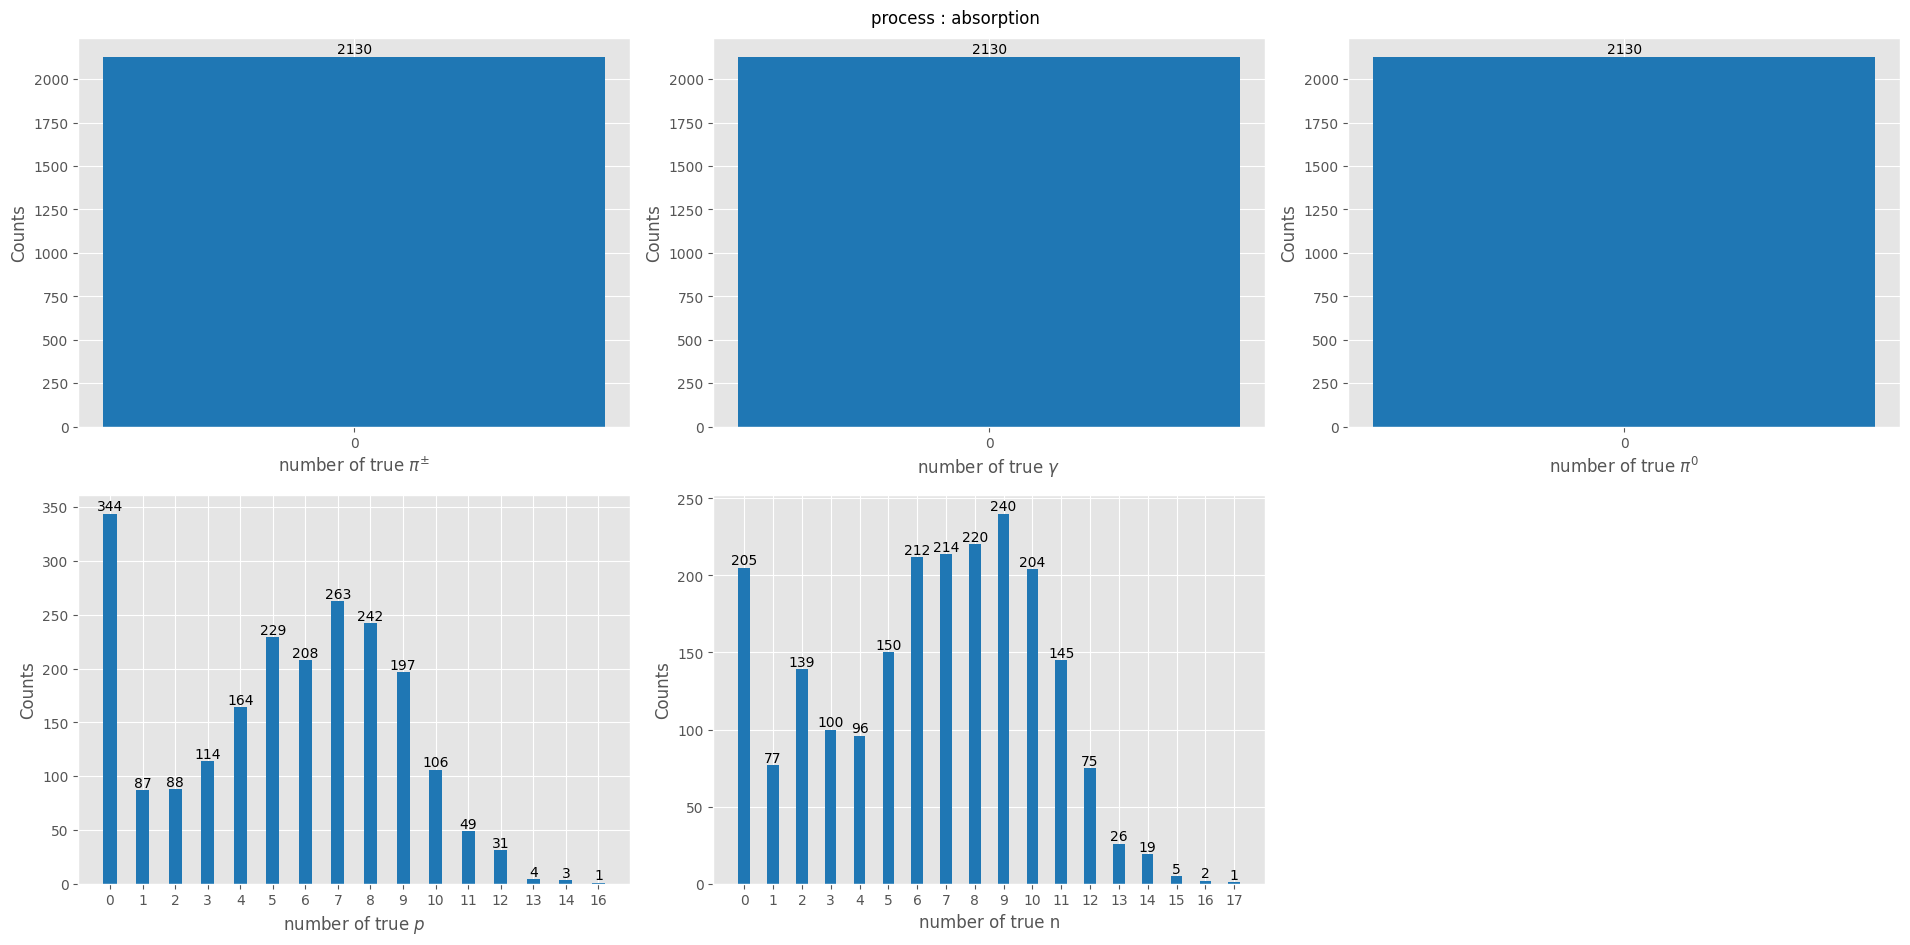

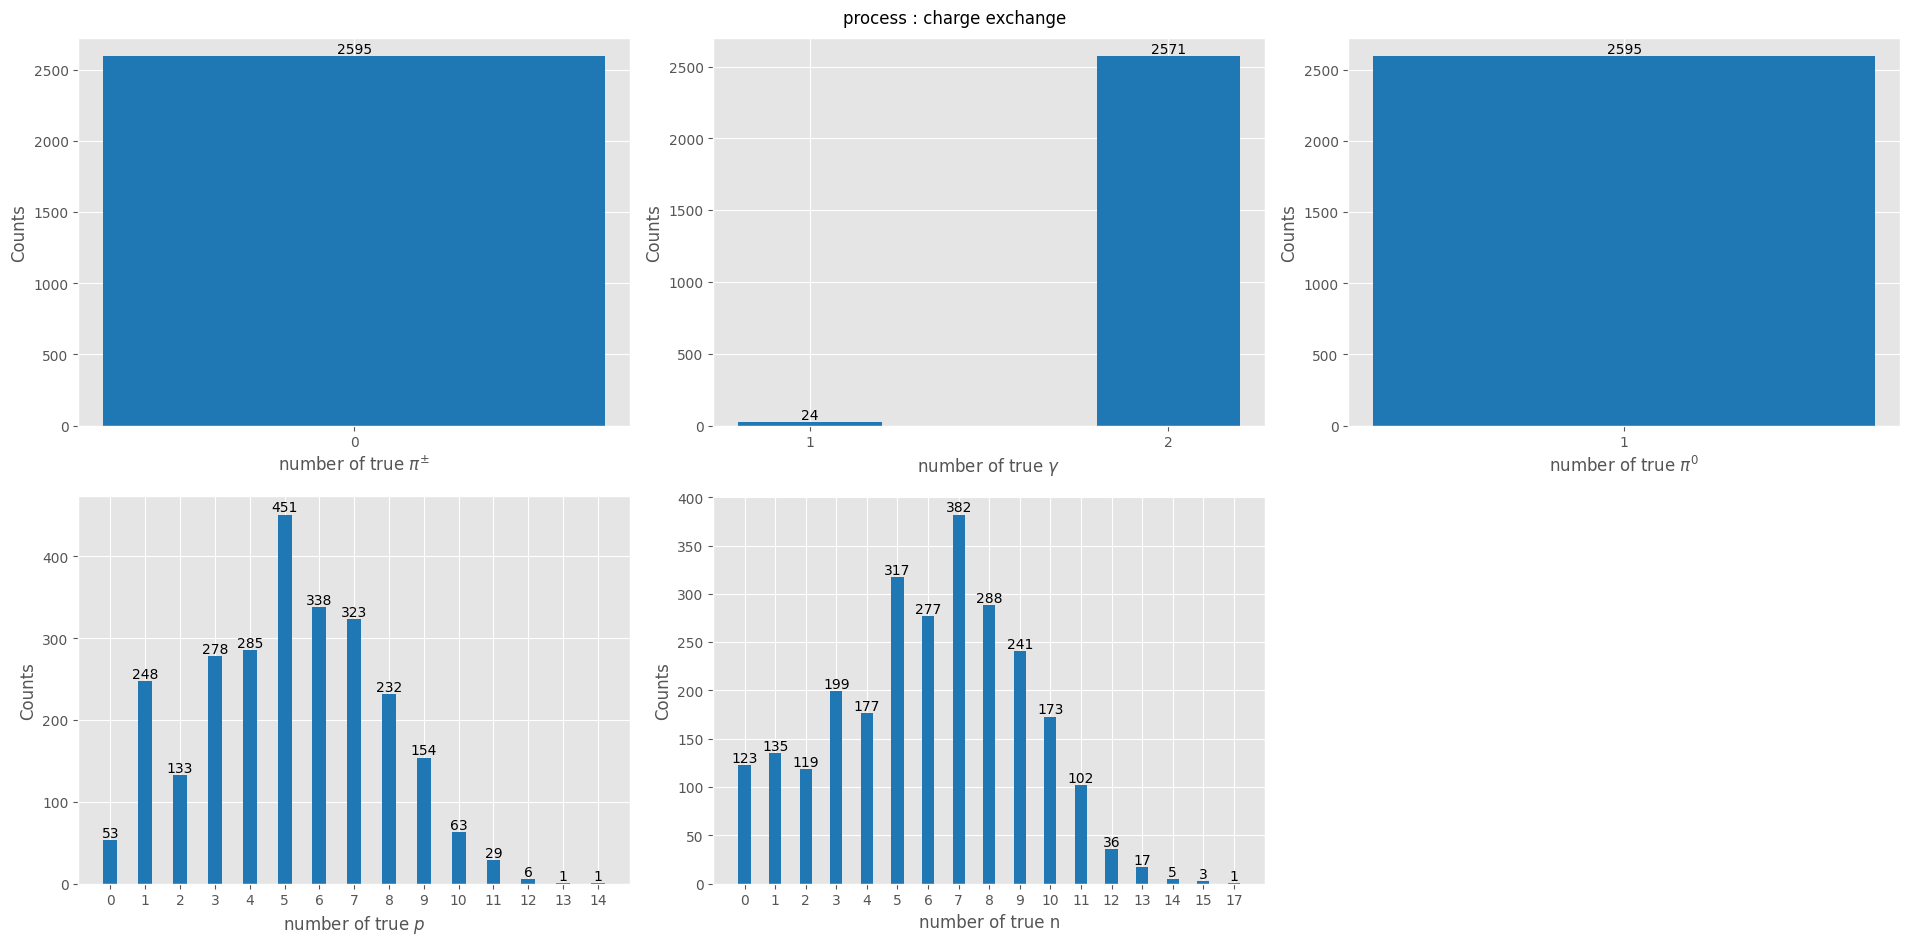

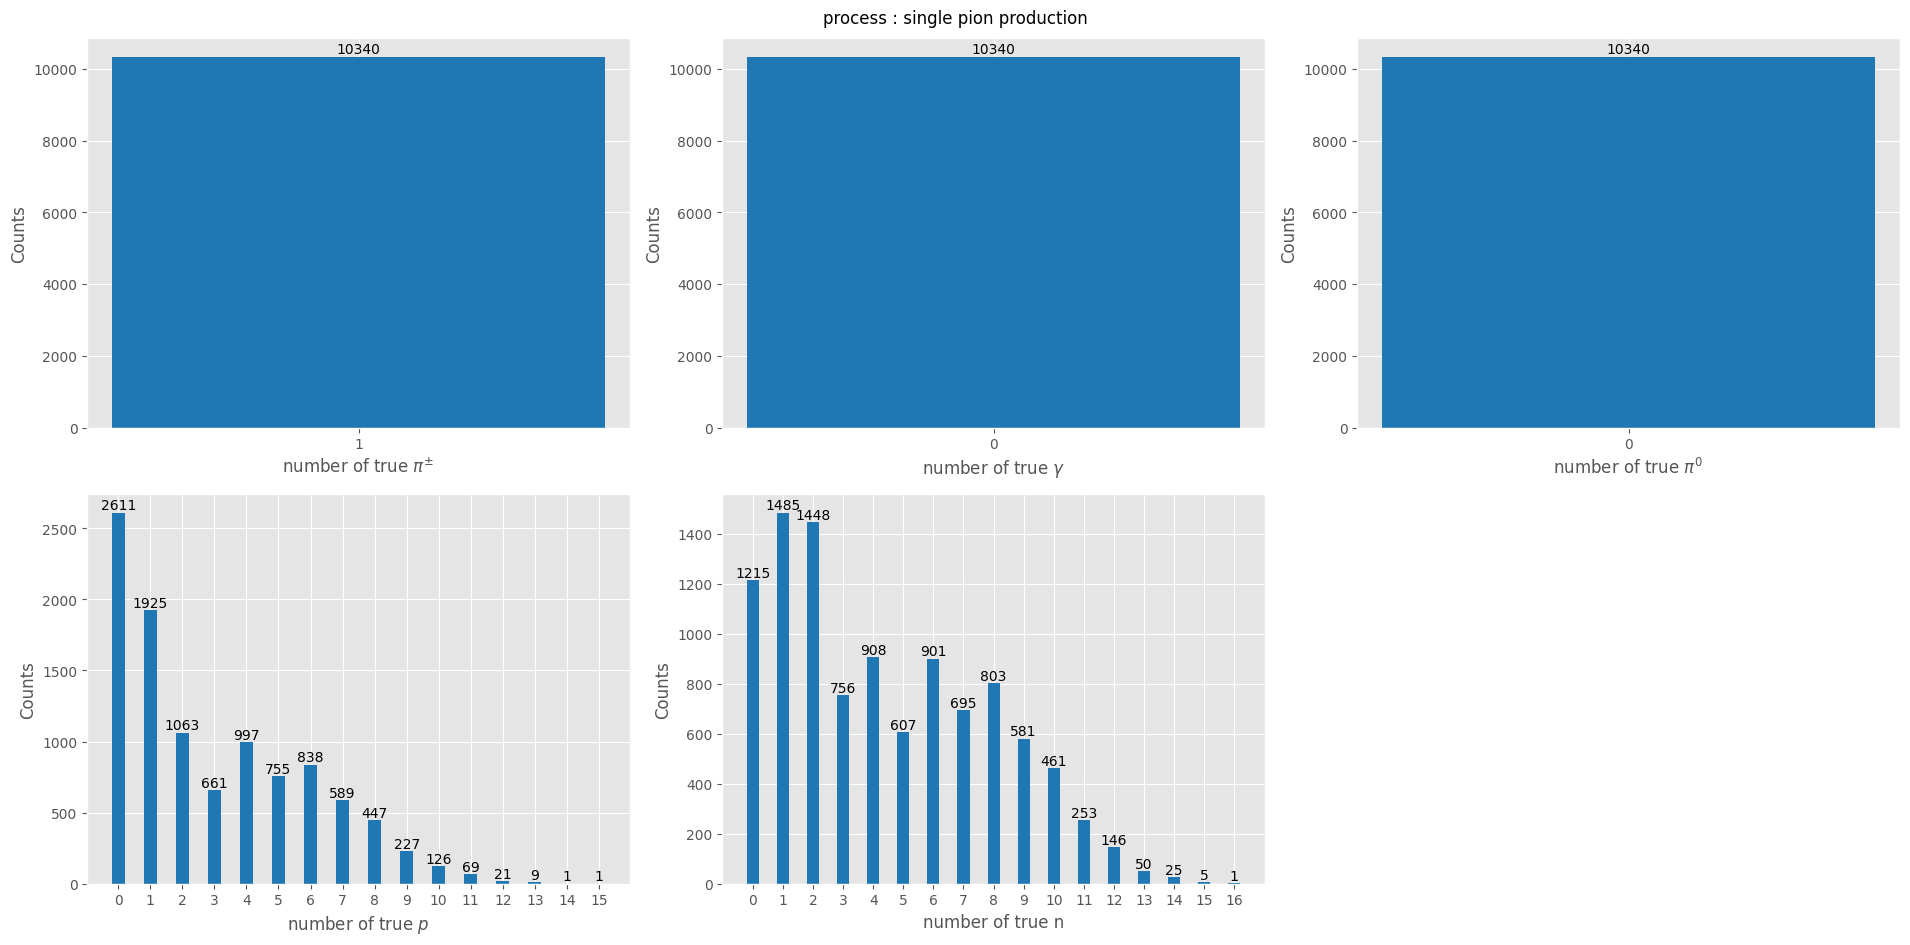

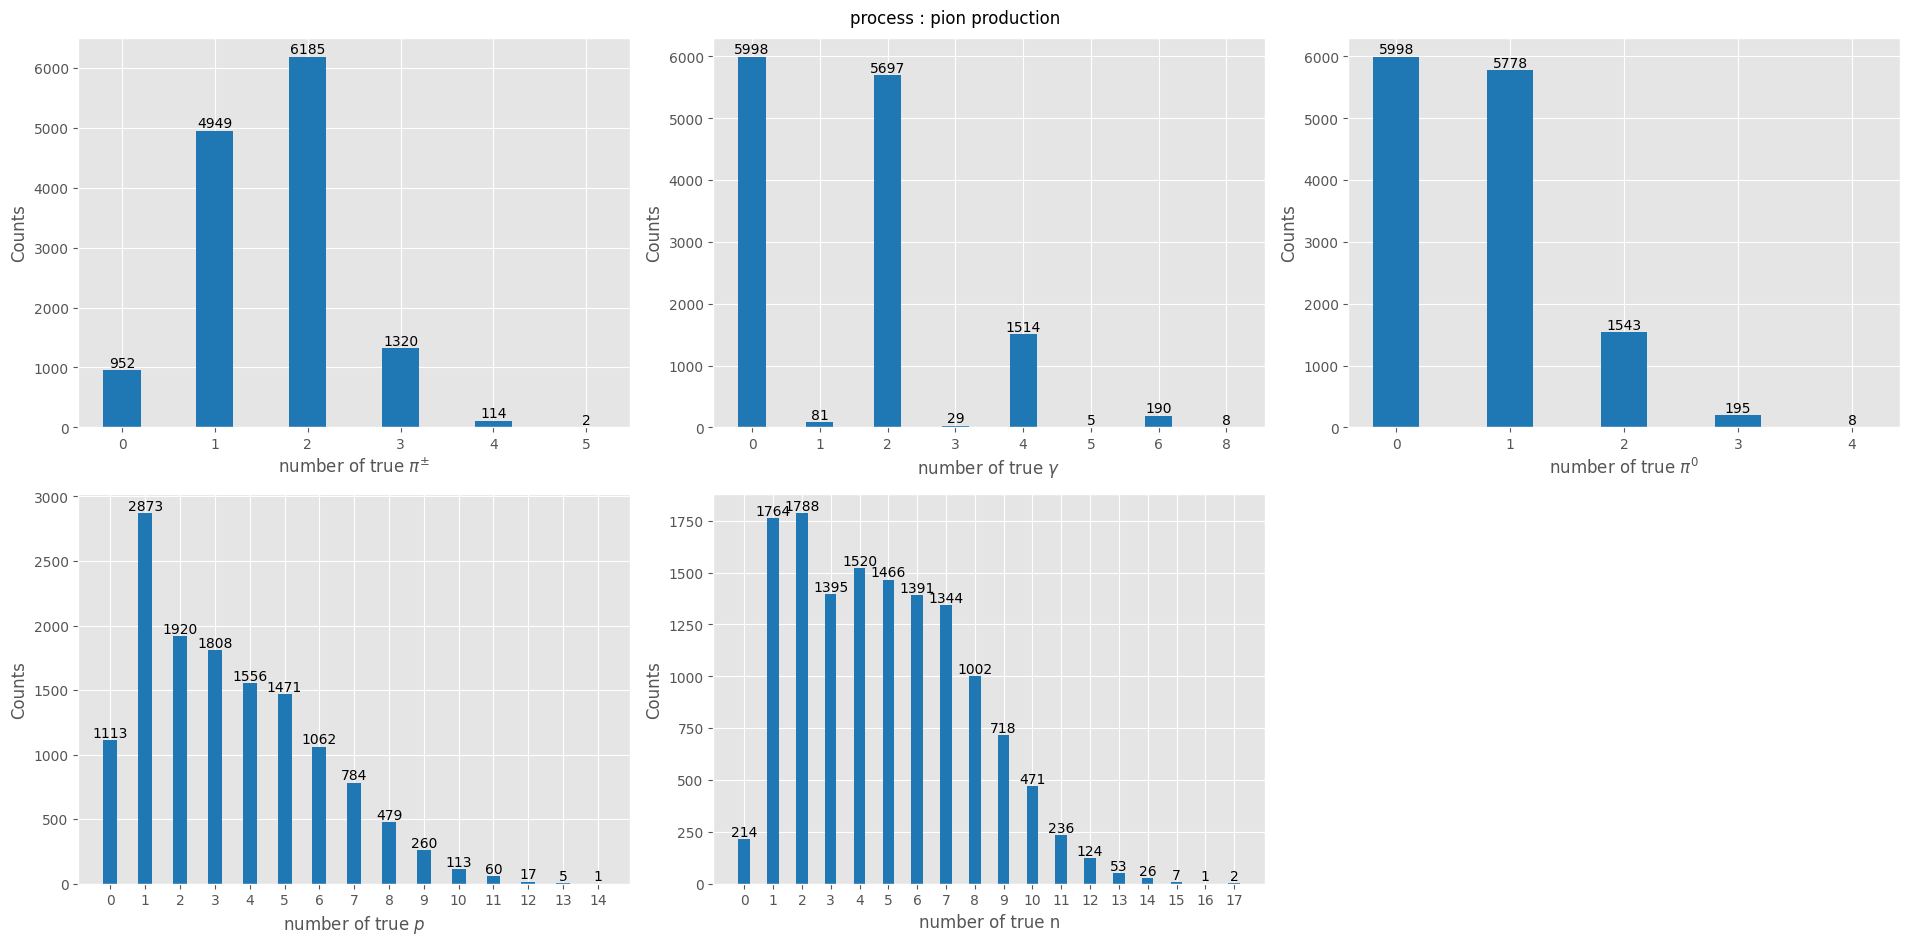

In [185]:
with Plots.PlotBook("process_composition_2GeV", False) as book:
    for t in true_regions:
        true_counts, _ = MakeParticleCounts(None, t)
        
        for _, k in Plots.IterMultiPlot(true_counts):
            Plots.PlotBar(true_counts[k], xlabel = f"number of true {labels[k]}", newFigure = False)
        Plots.plt.suptitle(f"process : {cross_section.remove_(t)}")
        Plots.plt.tight_layout()
        book.Save()